In [63]:
#  Installation des dépendances requises
%pip install imageio imageio-ffmpeg ipython --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Telechargeons gymnasium

In [64]:

!pip install gymnasium[classic-control] 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:

import os
import gymnasium as gym
from stable_baselines3 import PPO
import imageio
from IPython.display import Video, display


env = gym.make("CartPole-v1", render_mode="rgb_array")

model_path = "best_model_cartpole.zip"


if not os.path.exists(model_path):
    print("Training a new PPO model...")
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=50_000)
    model.save(model_path)
    print(" Model saved as:", model_path)
else:
    print("Loading existing model:", model_path)
    model = PPO.load(model_path, env=env)


frames = []
obs, _ = env.reset()
for _ in range(500):
    frame = env.render()
    frames.append(frame)
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
        obs, _ = env.reset()

video_path = "cartpole.mp4"
imageio.mimsave(video_path, frames, fps=30)
env.close()

display(Video(video_path, embed=True))

Training a new PPO model...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.5     |
|    ep_rew_mean     | 21.5     |
| time/              |          |
|    fps             | 3442     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.5     |
|    ep_rew_mean     | 21.5     |
| time/              |          |
|    fps             | 3442     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 26.1      |
|    ep_rew_mean          | 26.1      |
| time/                   |           

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from gymnasium import Env, spaces
from gymnasium.envs.registration import register
import random

class GridWorldEnv(Env):
    """
    Grid World Environment avec obstacles fixes
    
    L'agent doit atteindre l'objectif en évitant les obstacles 
    """
    
    def __init__(self, grid_size=8, obstacles_pattern="default"):
        super(GridWorldEnv, self).__init__()
        
        # Configuration de la grille
        self.grid_size = grid_size
        self.obstacles_pattern = obstacles_pattern
        
        # Espaces d'action et d'observation
        self.action_space = spaces.Discrete(4)  # Haut, Bas, Gauche, Droite
        self.observation_space = spaces.Box(
            low=0, high=grid_size-1, shape=(2,), dtype=np.int32
        )
        
        # Obstacles fixes selon le pattern
        self.obstacles = self._create_fixed_obstacles()
        
        # Initialisation
        self.reset()
        
    def _create_fixed_obstacles(self):
        """Crée des obstacles fixes selon un pattern défini"""
        obstacles = set()
        
        if self.obstacles_pattern == "default" and self.grid_size >= 6:
            # Pattern par défaut pour grille 6x6 ou plus
            obstacles.update([
                (1, 1), (1, 2), (1, 3),  # Mur horizontal
                (3, 1), (3, 2), (3, 3),  # Mur horizontal
                (2, 3), (4, 3),          # Colonnes verticales
                (0, 4), (1, 4),          # Bloc en haut à droite
            ])
        elif self.obstacles_pattern == "maze":
            # Pattern labyrinthe
            obstacles.update([
                (1, 1), (1, 3), (1, 4),
                (2, 1), (2, 4),
                (3, 0), (3, 1), (3, 3), (3, 4),
                (4, 3)
            ])
        elif self.obstacles_pattern == "corridor":
            # Pattern couloir
            for i in range(1, self.grid_size - 1):
                obstacles.add((2, i))
                obstacles.add((4, i))
            obstacles.remove((2, 1))  # Entrée du couloir
            obstacles.remove((4, self.grid_size - 2))  # Sortie du couloir
        
        # Filtrer les obstacles qui sortent de la grille
        obstacles = {obs for obs in obstacles if 0 <= obs[0] < self.grid_size and 0 <= obs[1] < self.grid_size}
        
        # S'assurer qu'aucun obstacle n'est sur les positions de départ et d'arrivée
        start_pos = (0, 0)
        goal_pos = (self.grid_size-1, self.grid_size-1)
        obstacles.discard(start_pos)
        obstacles.discard(goal_pos)
        
        return obstacles
        
    def reset(self, seed=None):
        """Réinitialise l'environnement"""
        super().reset(seed=seed)
        
        # Position fixe de l'agent (coin supérieur gauche)
        self.agent_pos = np.array([0, 0])
        
        # Position fixe de l'objectif (coin inférieur droit)
        self.goal_pos = np.array([self.grid_size-1, self.grid_size-1])
        
        # Historique des positions pour visualisation
        self.agent_path = [self.agent_pos.copy()]
        
        return self.agent_pos.copy(), {}
    
    def step(self, action):
        """Exécute une action dans l'environnement"""
        # Actions: 0=Haut, 1=Bas, 2=Gauche, 3=Droite
        moves = {
            0: np.array([-1, 0]),  # Haut
            1: np.array([1, 0]),   # Bas
            2: np.array([0, -1]),  # Gauche
            3: np.array([0, 1])    # Droite
        }
        
        # Nouvelle position proposée
        new_pos = self.agent_pos + moves[action]
        
        # Vérification des limites
        if (0 <= new_pos[0] < self.grid_size and 
            0 <= new_pos[1] < self.grid_size):
            
            # Vérification des obstacles
            if tuple(new_pos) not in self.obstacles:
                self.agent_pos = new_pos
                self.agent_path.append(self.agent_pos.copy())
        
        # Calcul de la récompense
        reward = self._calculate_reward()
        
        # Condition de fin
        terminated = np.array_equal(self.agent_pos, self.goal_pos)
        truncated = False
        
        return self.agent_pos.copy(), reward, terminated, truncated, {}
    
    def _calculate_reward(self):
        """Calcule la récompense"""
        if np.array_equal(self.agent_pos, self.goal_pos):
            return 100  # Récompense pour atteindre l'objectif
        else:
            # Récompense basée sur la distance à l'objectif
            distance = np.linalg.norm(self.agent_pos - self.goal_pos)
            return -1 - distance * 0.1  # Pénalité pour chaque pas + distance
    
    def render(self, mode='matplotlib', show_path=False):
        """Affiche l'environnement avec un style amélioré"""
        if mode == 'matplotlib':
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            ax.set_facecolor('#f0f8ff')  # Fond bleu clair
            
            # Créer une grille avec des cases colorées
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    # Cases libres avec effet damier subtil
                    if (i + j) % 2 == 0:
                        color = '#ffffff'  # Blanc
                    else:
                        color = '#f8f8ff'  # Blanc fantôme
                    
                    rect = patches.Rectangle(
                        (j, self.grid_size - i - 1), 1, 1,
                        linewidth=1, edgecolor='#d3d3d3', facecolor=color, alpha=0.8
                    )
                    ax.add_patch(rect)
            
            # Dessiner le chemin si demandé avec style amélioré
            if show_path and len(self.agent_path) > 1:
                path_x = [pos[1] + 0.5 for pos in self.agent_path]
                path_y = [self.grid_size - pos[0] - 0.5 for pos in self.agent_path]
                
                # Chemin principal avec gradient
                ax.plot(path_x, path_y, color='#ff6b6b', linewidth=4, alpha=0.8, 
                       linestyle='--', label='Chemin parcouru')
                
                # Points sur le chemin
                for idx, (x, y) in enumerate(zip(path_x[:-1], path_y[:-1])):
                    alpha = 0.3 + 0.7 * (idx / len(path_x))
                    ax.plot(x, y, 'o', color='#ff6b6b', markersize=6, alpha=alpha)
            
            # Dessiner les obstacles avec style 3D
            for obs in self.obstacles:
                x, y = obs[1], self.grid_size - obs[0] - 1
                
                # Ombre portée
                shadow = patches.Rectangle(
                    (x + 0.05, y - 0.05), 0.9, 0.9,
                    linewidth=0, facecolor='#666666', alpha=0.3
                )
                ax.add_patch(shadow)
                
                # Obstacle principal
                rect = patches.Rectangle(
                    (x, y), 1, 1,
                    linewidth=2, edgecolor='#2c3e50', facecolor='#34495e'
                )
                ax.add_patch(rect)
                
                # Effet de brillance
                highlight = patches.Rectangle(
                    (x + 0.1, y + 0.7), 0.3, 0.2,
                    linewidth=0, facecolor='#7f8c8d', alpha=0.6
                )
                ax.add_patch(highlight)
            
            # Dessiner l'objectif (carré vert simple)
            goal_x = self.goal_pos[1]
            goal_y = self.grid_size - self.goal_pos[0] - 1
            
            goal_rect = patches.Rectangle(
                (goal_x, goal_y), 1, 1,
                linewidth=2, edgecolor='green', facecolor='lightgreen'
            )
            ax.add_patch(goal_rect)
            
            # Dessiner l'agent comme une boule simple
            agent_x = self.agent_pos[1] + 0.5
            agent_y = self.grid_size - self.agent_pos[0] - 0.5
            
            # Corps de l'agent (boule bleue simple)
            agent_body = patches.Circle(
                (agent_x, agent_y), 0.35,
                linewidth=2, edgecolor='blue', facecolor='lightblue'
            )
            ax.add_patch(agent_body)
            
            # Grille fine
            for i in range(self.grid_size + 1):
                ax.axhline(i, color='#bdc3c7', linewidth=1, alpha=0.7)
                ax.axvline(i, color='#bdc3c7', linewidth=1, alpha=0.7)
            
            # Labels simples
            ax.text(goal_x + 0.5, goal_y + 0.5, 'GOAL', 
                   ha='center', va='center', fontsize=12, weight='bold', 
                   color='darkgreen')
            
            ax.text(agent_x, agent_y, 'AGENT', 
                   ha='center', va='center', fontsize=10, weight='bold', 
                   color='darkblue')
            
            # Configuration des axes
            ax.set_xlim(-0.1, self.grid_size + 0.1)
            ax.set_ylim(-0.1, self.grid_size + 0.1)
            ax.set_aspect('equal')
            
            # Titre simple
            title = f'Grid World - Agent: {self.agent_pos} Goal: {self.goal_pos}'
            if show_path:
                title += f' Steps: {len(self.agent_path)-1}'
            
            ax.set_title(title, fontsize=14, weight='bold')
            
            # Légende si chemin affiché
            if show_path and len(self.agent_path) > 1:
                ax.legend(loc='upper right', frameon=True, shadow=True, 
                         fancybox=True, framealpha=0.9)
            
            # Supprimer les ticks
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Cadre autour du graphique
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                spine.set_color('#34495e')
            
            plt.tight_layout()
            plt.show()
    
    def close(self):
        """Ferme l'environnement"""
        pass
print("Grid World Environment")

Grid World Environment


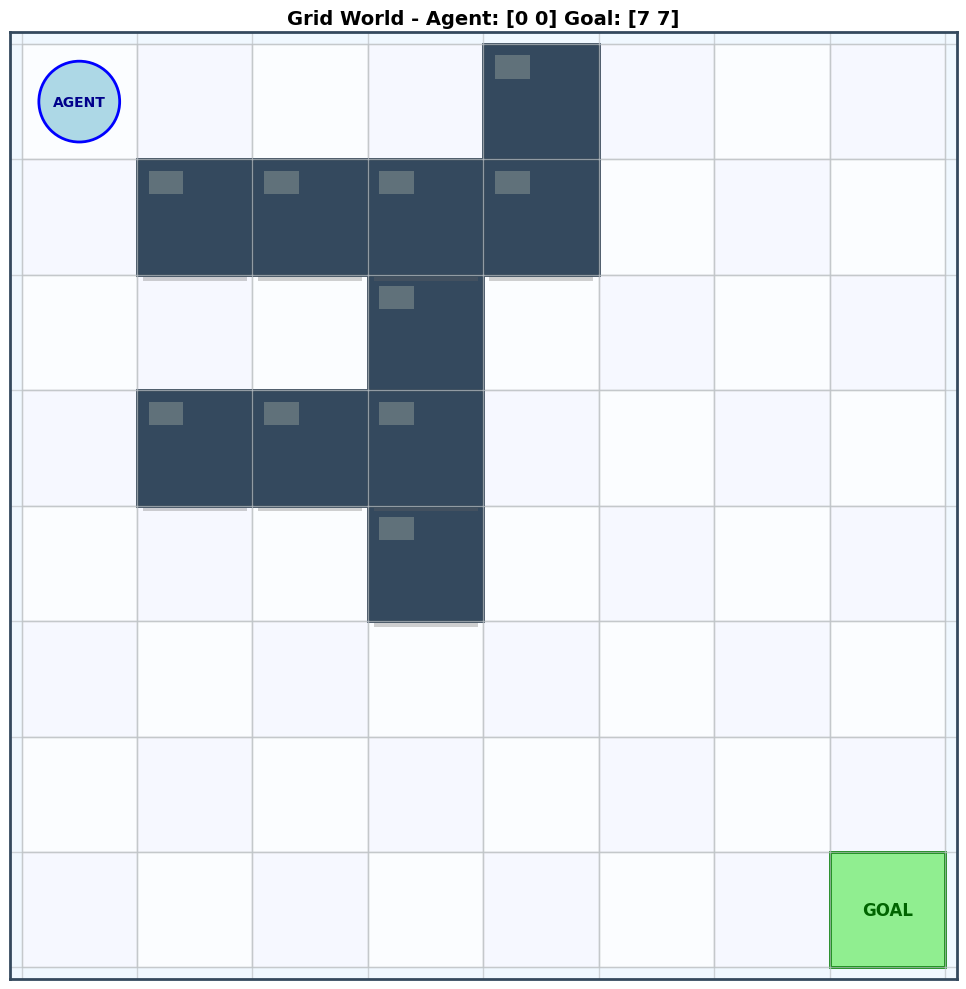

In [67]:
env= GridWorldEnv(grid_size=8)
env.render()

 Test de quelques mouvements:

 Action 1: Droite
Nouvelle position: [0 1]
Récompense: -1.92

 Action 2: Droite
Nouvelle position: [0 2]
Récompense: -1.86


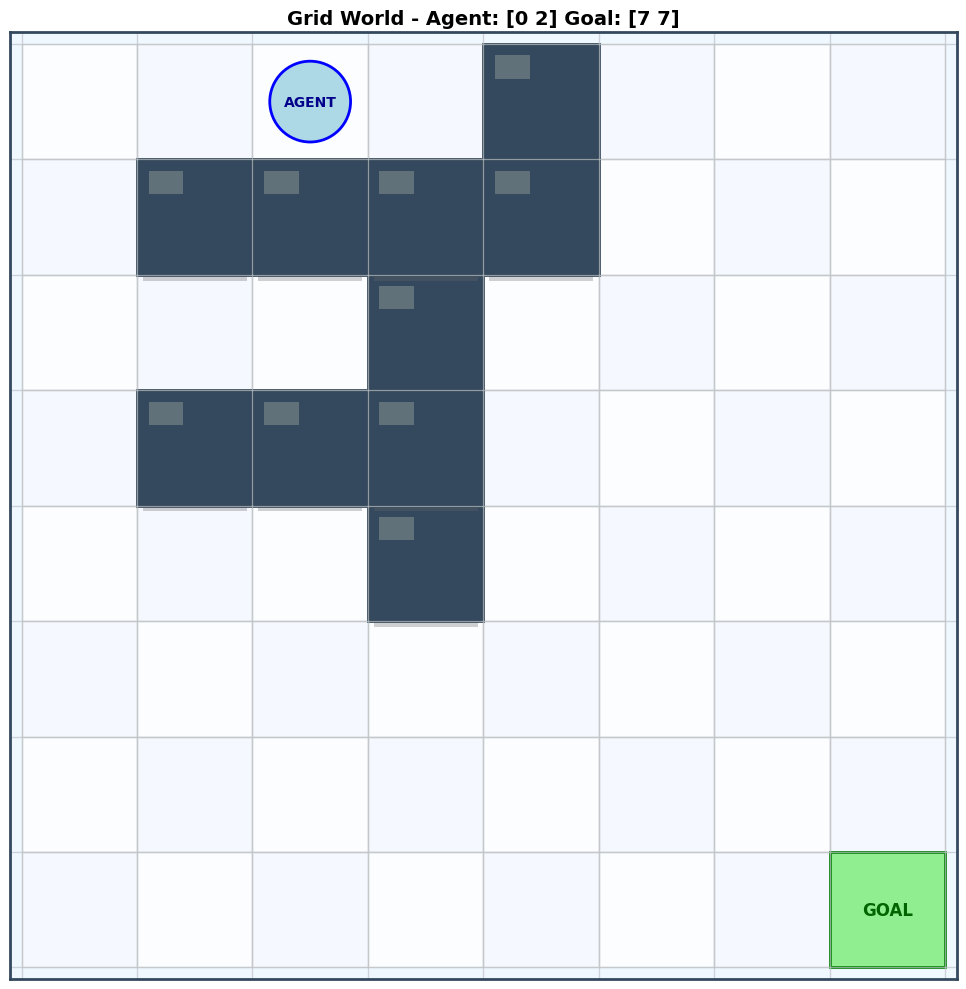


 Action 3: Bas
Nouvelle position: [0 2]
Récompense: -1.86

 Action 4: Bas
Nouvelle position: [0 2]
Récompense: -1.86


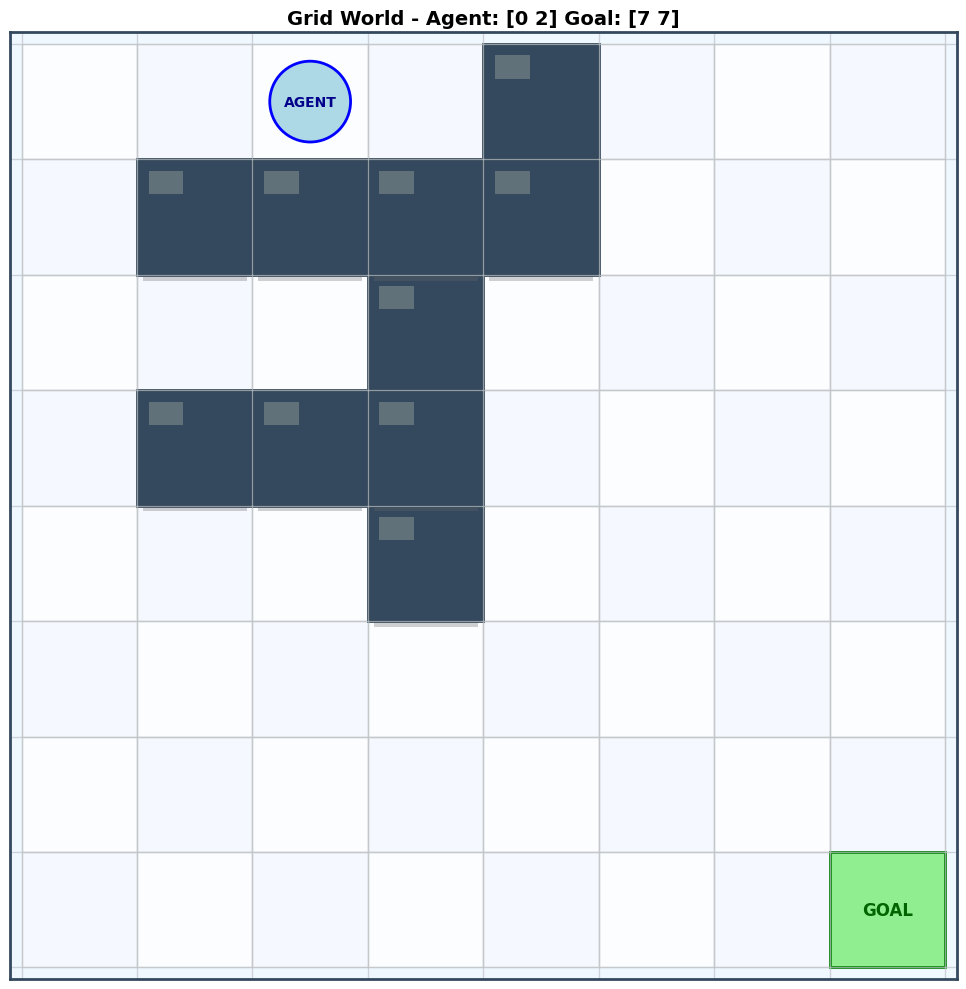


 Action 5: Droite
Nouvelle position: [0 3]
Récompense: -1.81

 Action 6: Bas
Nouvelle position: [0 3]
Récompense: -1.81


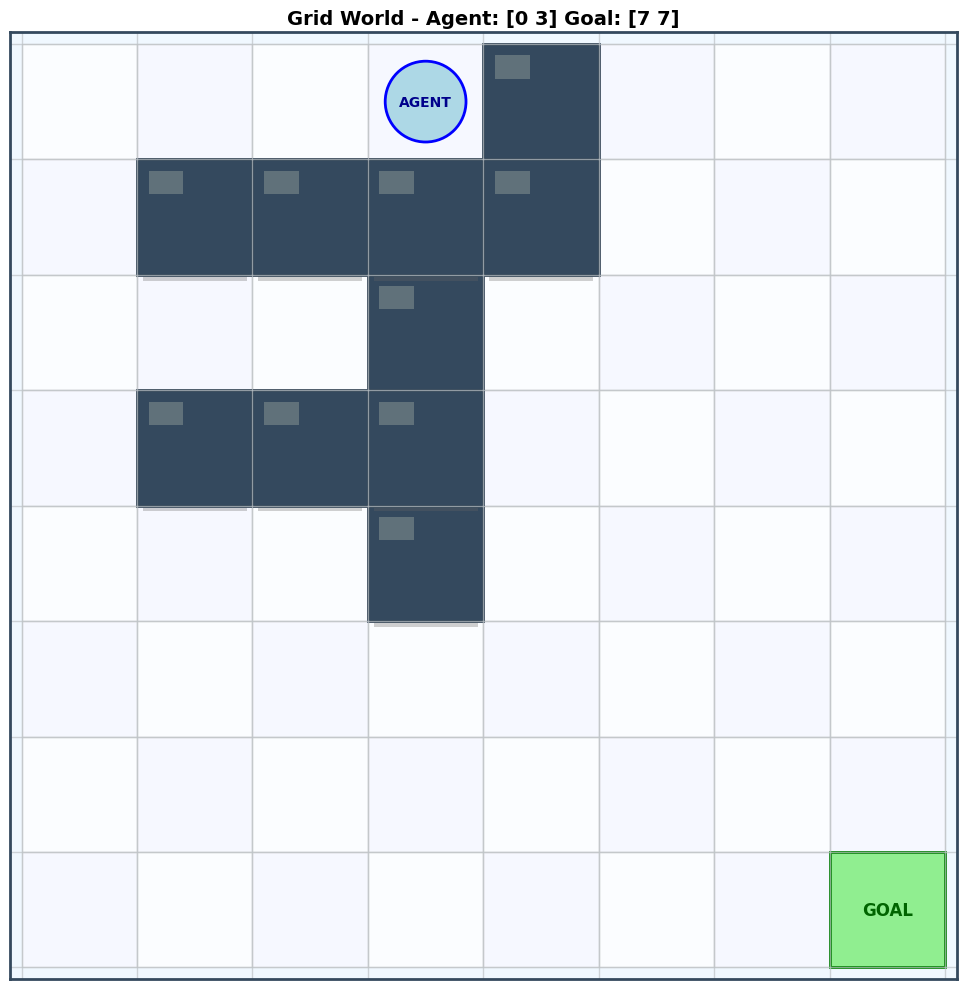

In [68]:
#  Test manuel de navigation
print(" Test de quelques mouvements:")

# Actions: 0=Haut, 1=Bas, 2=Gauche, 3=Droite
actions = [3, 3, 1, 1, 3, 1]  # Droite, Droite, Bas, Bas, Droite, Bas
action_names = ["Haut", "Bas", "Gauche", "Droite"]

for i, action in enumerate(actions):
    print(f"\n Action {i+1}: {action_names[action]}")
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Nouvelle position: {obs}")
    print(f"Récompense: {reward:.2f}")
    
    if terminated:
        print(" OBJECTIF ATTEINT !")
        break
    
    # Afficher la grille tous les 2 mouvements
    if (i + 1) % 2 == 0:
        env.render()

In [69]:
# Configuration d'un wrapper amélioré pour Grid World
from gymnasium.envs.registration import register
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
import time

class GridWorldWrapper(Env):
    """Wrapper amélioré pour rendre GridWorld compatible avec stable-baselines3"""
    
    def __init__(self, grid_size=6, obstacles_pattern="default"):
        super().__init__()
        self.env = GridWorldEnv(grid_size=grid_size, obstacles_pattern=obstacles_pattern)
        self.action_space = self.env.action_space
        
        # Observation étendue: position agent, position goal, distance, obstacles proches
        self.observation_space = spaces.Box(
            low=-1.0, high=1.0, shape=(8,), dtype=np.float32
        )
        
    def reset(self, seed=None):
        obs, info = self.env.reset(seed=seed)
        return self._get_obs(), info
    
    def step(self, action):
        # Convertir l'action en entier si nécessaire
        if isinstance(action, np.ndarray):
            action = int(action.item())
        obs, reward, terminated, truncated, info = self.env.step(action)
        return self._get_obs(), reward, terminated, truncated, info
    
    def _get_obs(self):
        """Retourne observation étendue normalisée"""
        agent_pos = self.env.agent_pos.astype(np.float32)
        goal_pos = self.env.goal_pos.astype(np.float32)
        grid_size = self.env.grid_size - 1
        
        # Positions normalisées [-1, 1]
        agent_norm = (agent_pos / grid_size) * 2 - 1
        goal_norm = (goal_pos / grid_size) * 2 - 1
        
        # Distance relative
        distance = np.linalg.norm(agent_pos - goal_pos) / (grid_size * np.sqrt(2))
        
        # Obstacles dans les 4 directions (0=libre, 1=obstacle/mur)
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Haut, Bas, Gauche, Droite
        obstacles_nearby = []
        
        for dx, dy in directions:
            next_pos = agent_pos + np.array([dx, dy])
            if (next_pos[0] < 0 or next_pos[0] >= self.env.grid_size or 
                next_pos[1] < 0 or next_pos[1] >= self.env.grid_size or 
                tuple(next_pos) in self.env.obstacles):
                obstacles_nearby.append(1.0)
            else:
                obstacles_nearby.append(0.0)
        
        obs = np.array([
            agent_norm[0], agent_norm[1],  # Position agent normalisée
            goal_norm[0], goal_norm[1],    # Position goal normalisée
            distance,                       # Distance normalisée
            obstacles_nearby[0],           # Obstacle en haut
            obstacles_nearby[1],           # Obstacle en bas
            obstacles_nearby[2],           # Obstacle à gauche
        ], dtype=np.float32)
        
        return obs
    
    def render(self, mode='matplotlib', show_path=False):
        return self.env.render(mode, show_path)
    
    def close(self):
        return self.env.close()

print("Wrapper GridWorld amélioré créé")

Wrapper GridWorld amélioré créé


Test de l'environnement GridWorld wrapper...
Position initiale:
Agent: [0 0]
Goal: [5 5]
Obstacles: 10
Observation initiale: [-1. -1.  1.  1.  1.  1.  0.  1.]
Shape de l'observation: (8,)
Type de l'observation: <class 'numpy.ndarray'>
Après action 3: obs=[-1.        -0.6        1.         1.         0.9055385  1.
  1.         0.       ], reward=-1.64


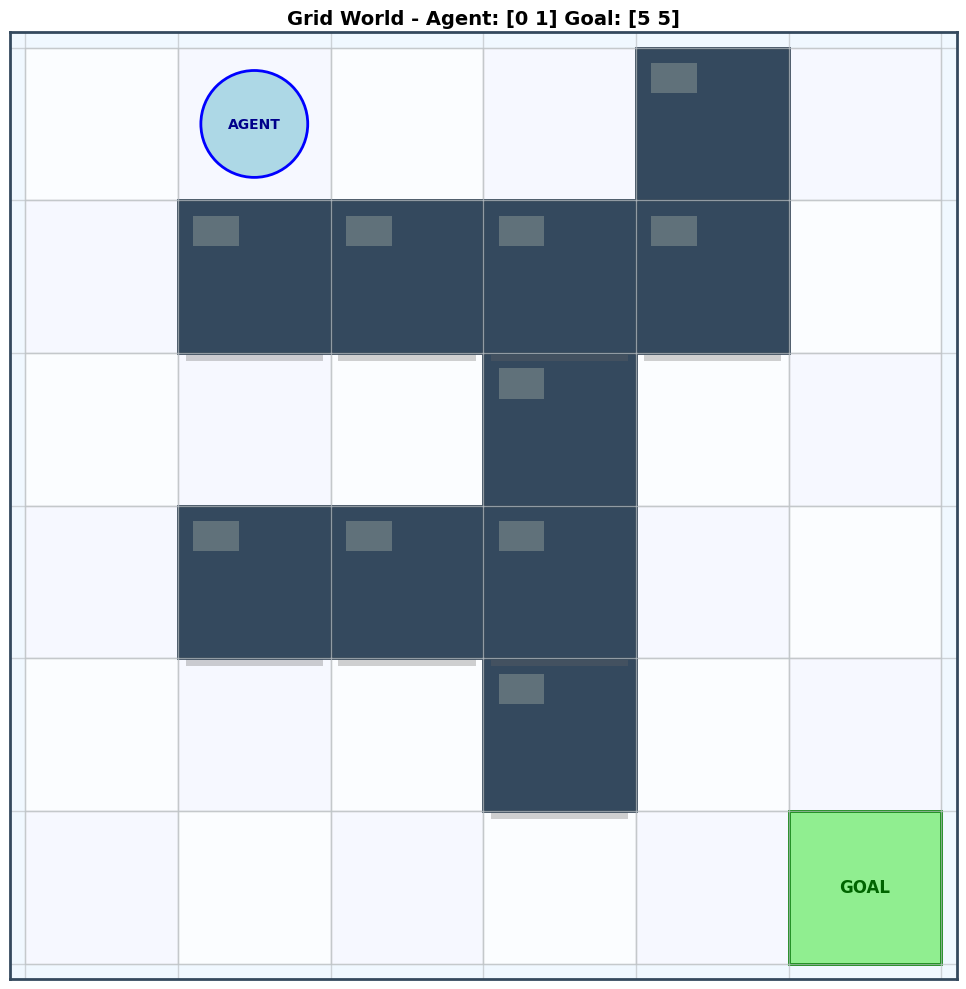

Environnement wrappé testé avec succès


In [70]:
# Test simple de l'environnement wrappé
print("Test de l'environnement GridWorld wrapper...")

# Création d'un nouvel environnement avec le wrapper corrigé
wrapped_env = GridWorldWrapper(grid_size=6)

print("Position initiale:")
print(f"Agent: {wrapped_env.env.agent_pos}")
print(f"Goal: {wrapped_env.env.goal_pos}")
print(f"Obstacles: {len(wrapped_env.env.obstacles)}")

# Test d'observation
obs, info = wrapped_env.reset()
print(f"Observation initiale: {obs}")
print(f"Shape de l'observation: {obs.shape}")
print(f"Type de l'observation: {type(obs)}")

# Test d'une action
action = wrapped_env.action_space.sample()
obs, reward, terminated, truncated, info = wrapped_env.step(action)
print(f"Après action {action}: obs={obs}, reward={reward:.2f}")

# Affichage
wrapped_env.render()

print("Environnement wrappé testé avec succès")

learning_rate            : 0.0001
buffer_size              : 50000
learning_starts          : 1000
target_update_interval   : 1000
train_freq               : 1
gradient_steps           : 1
exploration_fraction     : 0.1
exploration_initial_eps  : 1.0
exploration_final_eps    : 0.01
gamma                    : 0.99
tau                      : 1.0
policy                   : MlpPolicy
net_arch                 : [256, 256]
batch_size               : 64
max_grad_norm            : 10
Création de l'environnement Grid World avec obstacles fixes...
Obstacles fixes: [(0, 4), (1, 1), (1, 2), (1, 3), (1, 4), (2, 3), (3, 1), (3, 2), (3, 3), (4, 3)]
Agent start: [0 0]
Goal: [5 5]


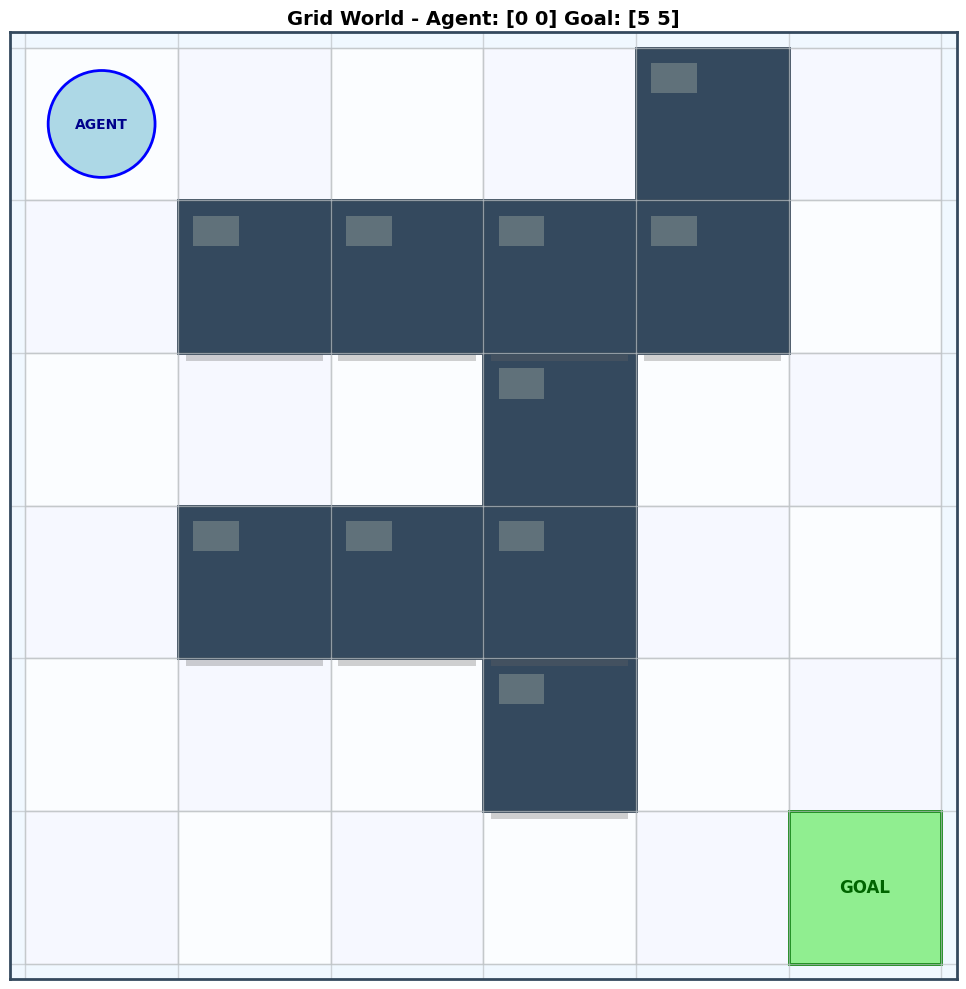


Création du callback d'enregistrement...
Création du modèle DQN...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

Début de l'entraînement DQN...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 315      |
|    ep_rew_mean      | -378     |
|    exploration_rate | 0.376    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1924     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1261     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0777   |
|    n_updates        | 260      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 315      |
|    ep_rew_mean      | -378     |
|    exploration_rate | 0.376    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1924     |
|

In [71]:
# Entraînement DQN amélioré avec enregistrement des vraies étapes
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import io
import copy

class TrainingRecorder(BaseCallback):
    """Callback pour enregistrer les vraies étapes d'entraînement"""
    
    def __init__(self, env, record_freq=2000, test_freq=1000, verbose=0):
        super(TrainingRecorder, self).__init__(verbose)
        self.env = env
        self.record_freq = record_freq
        self.test_freq = test_freq
        self.frames = []
        self.training_stats = []
        self.episode_rewards = []
        self.episode_lengths = []
        self.current_episode_reward = 0
        self.current_episode_length = 0
        self.episode_count = 0
        self.timesteps = []
        
    def _on_step(self) -> bool:
        # Incrémenter la longueur de l'épisode
        self.current_episode_length += 1
        
        # Enregistrer les récompenses
        reward = self.locals.get('reward', 0)
        if isinstance(reward, (list, tuple)):
            reward = reward[0] if len(reward) > 0 else 0
        self.current_episode_reward += reward
        
        # Détecter fin d'épisode via 'dones' ou 'done'
        done = False
        if 'dones' in self.locals:
            done = self.locals['dones'][0] if isinstance(self.locals['dones'], (list, tuple)) else self.locals['dones']
        elif 'done' in self.locals:
            done = self.locals['done']
            
        if done:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_lengths.append(self.current_episode_length)
            self.timesteps.append(self.n_calls)
            self.episode_count += 1
            
            if self.verbose > 0 and self.episode_count % 10 == 0:
                print(f"Episode {self.episode_count}: Reward={self.current_episode_reward:.2f}, Length={self.current_episode_length}")
            
            # Reset pour le nouvel épisode
            self.current_episode_reward = 0
            self.current_episode_length = 0
        
        # Test périodique avec enregistrement
        if self.n_calls % self.test_freq == 0:
            frame = self._test_and_record()
            if frame is not None:
                self.frames.append(frame)
                
        return True
    
    def _test_and_record(self):
        """Teste l'agent actuel et enregistre une frame"""
        try:
            # Sauvegarder l'état de l'environnement
            old_agent_pos = copy.deepcopy(self.env.env.agent_pos)
            old_path = copy.deepcopy(self.env.env.agent_path)
            
            # Reset pour test
            obs, _ = self.env.reset()
            
            # Jouer un épisode court pour tester
            positions = [self.env.env.agent_pos.copy()]
            episode_reward = 0
            
            for step in range(15):  # Limiter à 15 steps pour le test
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                episode_reward += reward
                positions.append(self.env.env.agent_pos.copy())
                
                if terminated or truncated:
                    break
            
            # Créer la frame
            frame = self._create_frame(positions, episode_reward, self.n_calls)
            
            # Restaurer l'état de l'environnement
            self.env.env.agent_pos = old_agent_pos
            self.env.env.agent_path = old_path
            
            return frame
            
        except Exception as e:
            print(f"Erreur lors de l'enregistrement: {e}")
            return None
    
    def _create_frame(self, positions, reward, step):
        """Crée une frame de visualisation avec style amélioré"""
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set_facecolor('#f0f8ff')
        
        grid_size = self.env.env.grid_size
        
        # Créer une grille avec effet damier
        for i in range(grid_size):
            for j in range(grid_size):
                if (i + j) % 2 == 0:
                    color = '#ffffff'
                else:
                    color = '#f8f8ff'
                
                rect = patches.Rectangle(
                    (j, grid_size - i - 1), 1, 1,
                    linewidth=1, edgecolor='#d3d3d3', facecolor=color, alpha=0.8
                )
                ax.add_patch(rect)
        
        # Dessiner le chemin parcouru avec style
        if len(positions) > 1:
            path_x = [pos[1] + 0.5 for pos in positions]
            path_y = [grid_size - pos[0] - 0.5 for pos in positions]
            ax.plot(path_x, path_y, color='#ff6b6b', linewidth=4, alpha=0.8,
                   linestyle='--', label='Chemin de test')
        
        # Dessiner les obstacles avec style 3D
        for obs in self.env.env.obstacles:
            x, y = obs[1], grid_size - obs[0] - 1
            
            # Ombre
            shadow = patches.Rectangle(
                (x + 0.05, y - 0.05), 0.9, 0.9,
                linewidth=0, facecolor='#666666', alpha=0.3
            )
            ax.add_patch(shadow)
            
            # Obstacle
            rect = patches.Rectangle(
                (x, y), 1, 1,
                linewidth=2, edgecolor='#2c3e50', facecolor='#34495e'
            )
            ax.add_patch(rect)
        
        # Dessiner l'objectif (carré vert)
        goal_x = self.env.env.goal_pos[1]
        goal_y = grid_size - self.env.env.goal_pos[0] - 1
        
        goal_rect = patches.Rectangle(
            (goal_x, goal_y), 1, 1,
            linewidth=2, edgecolor='green', facecolor='lightgreen'
        )
        ax.add_patch(goal_rect)
        
        # Dessiner l'agent comme une boule simple
        final_pos = positions[-1]
        agent_x = final_pos[1] + 0.5
        agent_y = grid_size - final_pos[0] - 0.5
        
        # Corps de l'agent (boule bleue simple)
        agent_body = patches.Circle(
            (agent_x, agent_y), 0.35,
            linewidth=2, edgecolor='blue', facecolor='lightblue'
        )
        ax.add_patch(agent_body)
        
        # Grille
        for i in range(grid_size + 1):
            ax.axhline(i, color='#bdc3c7', linewidth=1, alpha=0.7)
            ax.axvline(i, color='#bdc3c7', linewidth=1, alpha=0.7)
        
        ax.set_xlim(-0.1, grid_size + 0.1)
        ax.set_ylim(-0.1, grid_size + 0.1)
        ax.set_aspect('equal')
        
        # Titre simple
        avg_reward = np.mean(self.episode_rewards[-10:]) if len(self.episode_rewards) >= 10 else 0
        ax.set_title(f'Training Progress\nStep: {step:,} | Test Reward: {reward:.1f} | Avg: {avg_reward:.1f}\nEpisode: {self.episode_count}', 
                    fontsize=12, weight='bold')
        
        if len(positions) > 1:
            ax.legend(loc='upper right', frameon=True, shadow=True)
        
        # Supprimer les ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Convertir en array
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
        buf.seek(0)
        plt.close()
        
        import PIL.Image
        img = PIL.Image.open(buf)
        frame = np.array(img)
        buf.close()
        
        return frame

# Affichage des hyperparamètres DQN optimisés pour environnements discrets



hyperparams = {
    "learning_rate": 0.0001,           # Plus faible pour stabilité
    "buffer_size": 50000,              # Buffer plus grand
    "learning_starts": 1000,           # Commencer l'apprentissage après exploration
    "target_update_interval": 1000,    # Mise à jour moins fréquente du réseau cible
    "train_freq": 1,                   # Entraîner à chaque step
    "gradient_steps": 1,               # Un gradient step par entraînement
    "exploration_fraction": 0.1,       # 10% du temps pour l'exploration
    "exploration_initial_eps": 1.0,    # Exploration maximale au début
    "exploration_final_eps": 0.01,     # Exploration minimale en fin
    "gamma": 0.99,                     # Facteur de discount standard
    "tau": 1.0,                        # Hard update du réseau cible
    "policy": "MlpPolicy",             # Politique MLP
    "net_arch": "[256, 256]",          # Architecture plus profonde
    "batch_size": 64,                  # Taille de batch standard
    "max_grad_norm": 10                # Gradient clipping
}

for param, value in hyperparams.items():
    print(f"{param:25}: {value}")

print("=" * 50)

# Créer l'environnement avec obstacles fixes
print("Création de l'environnement Grid World avec obstacles fixes...")
wrapped_env = GridWorldWrapper(grid_size=6, obstacles_pattern="default")

print(f"Obstacles fixes: {sorted(list(wrapped_env.env.obstacles))}")
print(f"Agent start: {wrapped_env.env.agent_pos}")
print(f"Goal: {wrapped_env.env.goal_pos}")

# Affichage initial
wrapped_env.render()

# Callback d'enregistrement amélioré
print("\nCréation du callback d'enregistrement...")
recorder = TrainingRecorder(wrapped_env, record_freq=2000, test_freq=2000)

# Modèle DQN avec hyperparamètres optimisés
print("Création du modèle DQN...")
model = DQN(
    hyperparams["policy"],
    wrapped_env,
    learning_rate=hyperparams["learning_rate"],
    buffer_size=hyperparams["buffer_size"],
    learning_starts=hyperparams["learning_starts"],
    target_update_interval=hyperparams["target_update_interval"],
    train_freq=hyperparams["train_freq"],
    gradient_steps=hyperparams["gradient_steps"],
    exploration_fraction=hyperparams["exploration_fraction"],
    exploration_initial_eps=hyperparams["exploration_initial_eps"],
    exploration_final_eps=hyperparams["exploration_final_eps"],
    verbose=1
)

print("\nDébut de l'entraînement DQN...")
start_time = time.time()

model.learn(total_timesteps=20000, callback=recorder)

training_time = time.time() - start_time
print(f"\nEntraînement terminé en {training_time:.2f} secondes")
print(f"Nombre de frames d'entraînement: {len(recorder.frames)}")
print(f"Nombre d'épisodes: {recorder.episode_count}")

# Sauvegarder le GIF d'entraînement
if len(recorder.frames) > 0:
    training_gif_path = "dqn_training_evolution.gif"
    imageio.mimsave(training_gif_path, recorder.frames, duration=1.5)
    print(f"GIF d'évolution de l'entraînement: {training_gif_path}")
else:
    print("Aucune frame d'entraînement enregistrée")

Génération du graphique de convergence DQN...


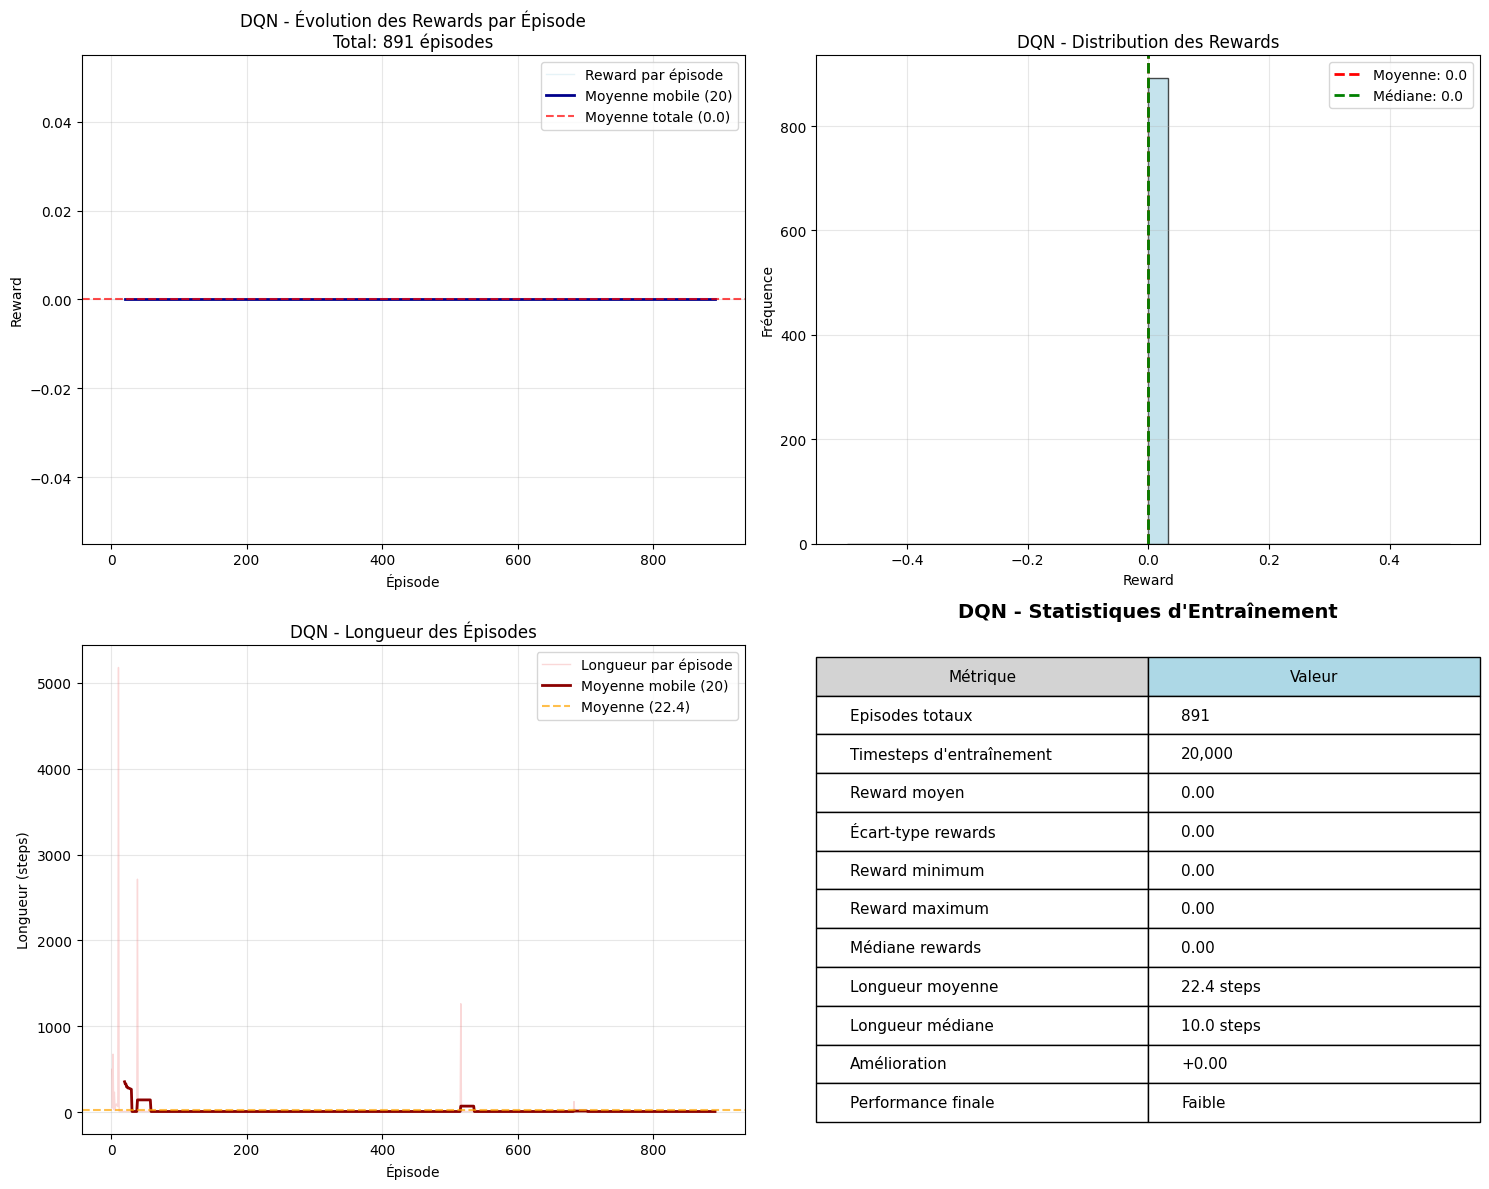


Résumé de l'entraînement DQN:
Episodes: 891 | Timesteps: 20,000
Reward moyen: 0.00 ± 0.00
Range: [0.00, 0.00]
Longueur moyenne: 22.4 steps
Amélioration: +0.00 (premier vs dernier quart)
Performance: Faible


In [72]:
# Visualisation de convergence DQN avec données d'épisodes
def plot_dqn_training_convergence(recorder, save_path="dqn_convergence.png"):
    """Visualise la convergence de l'entraînement DQN avec épisodes et rewards"""
    
    if len(recorder.episode_rewards) == 0:
        print("Pas de données d'épisodes disponibles pour DQN")
        return
    
    # Préparation des données
    episodes = list(range(1, len(recorder.episode_rewards) + 1))
    rewards = np.array(recorder.episode_rewards)
    lengths = np.array(recorder.episode_lengths) if len(recorder.episode_lengths) > 0 else None
    
    # Calcul des moyennes mobiles
    window_size = max(1, min(20, len(rewards) // 5))
    if window_size > 1:
        moving_avg_rewards = np.convolve(rewards, np.ones(window_size), 'valid') / window_size
        moving_avg_episodes = episodes[window_size-1:]
        
        if lengths is not None:
            moving_avg_lengths = np.convolve(lengths, np.ones(window_size), 'valid') / window_size
    else:
        moving_avg_rewards = rewards
        moving_avg_episodes = episodes
        moving_avg_lengths = lengths
    
    # Création du graphique avec 3 sous-graphiques
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Graphique 1: Evolution des rewards par épisode
    ax1.plot(episodes, rewards, alpha=0.3, color='lightblue', linewidth=1, label='Reward par épisode')
    if window_size > 1:
        ax1.plot(moving_avg_episodes, moving_avg_rewards, color='darkblue', linewidth=2, 
                label=f'Moyenne mobile ({window_size})')
    
    ax1.axhline(y=np.mean(rewards), color='red', linestyle='--', alpha=0.7, 
               label=f'Moyenne totale ({np.mean(rewards):.1f})')
    
    ax1.set_xlabel('Épisode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'DQN - Évolution des Rewards par Épisode\nTotal: {len(episodes)} épisodes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Distribution des rewards
    ax2.hist(rewards, bins=min(30, len(rewards)//3), alpha=0.7, color='lightblue', edgecolor='black')
    ax2.axvline(x=np.mean(rewards), color='red', linestyle='--', linewidth=2,
               label=f'Moyenne: {np.mean(rewards):.1f}')
    ax2.axvline(x=np.median(rewards), color='green', linestyle='--', linewidth=2,
               label=f'Médiane: {np.median(rewards):.1f}')
    
    ax2.set_xlabel('Reward')
    ax2.set_ylabel('Fréquence')
    ax2.set_title('DQN - Distribution des Rewards')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Graphique 3: Evolution de la longueur des épisodes (si disponible)
    if lengths is not None and len(lengths) > 0:
        ax3.plot(episodes, lengths, alpha=0.3, color='lightcoral', linewidth=1, label='Longueur par épisode')
        if window_size > 1:
            ax3.plot(moving_avg_episodes, moving_avg_lengths, color='darkred', linewidth=2,
                    label=f'Moyenne mobile ({window_size})')
        
        ax3.axhline(y=np.mean(lengths), color='orange', linestyle='--', alpha=0.7,
                   label=f'Moyenne ({np.mean(lengths):.1f})')
        
        ax3.set_xlabel('Épisode')
        ax3.set_ylabel('Longueur (steps)')
        ax3.set_title('DQN - Longueur des Épisodes')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Données de longueur\nnon disponibles', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=14)
        ax3.set_title('DQN - Longueur des Épisodes')
    
    # Graphique 4: Statistiques détaillées (tableau)
    ax4.axis('off')
    
    # Calcul des statistiques
    stats_data = [
        ['Episodes totaux', f'{len(episodes)}'],
        ['Timesteps d\'entraînement', '20,000'],
        ['Reward moyen', f'{np.mean(rewards):.2f}'],
        ['Écart-type rewards', f'{np.std(rewards):.2f}'],
        ['Reward minimum', f'{np.min(rewards):.2f}'],
        ['Reward maximum', f'{np.max(rewards):.2f}'],
        ['Médiane rewards', f'{np.median(rewards):.2f}'],
    ]
    
    if lengths is not None and len(lengths) > 0:
        stats_data.extend([
            ['Longueur moyenne', f'{np.mean(lengths):.1f} steps'],
            ['Longueur médiane', f'{np.median(lengths):.1f} steps'],
        ])
    
    # Calcul de l'amélioration
    if len(rewards) >= 20:
        first_quarter = rewards[:len(rewards)//4]
        last_quarter = rewards[-len(rewards)//4:]
        improvement = np.mean(last_quarter) - np.mean(first_quarter)
        stats_data.append(['Amélioration', f'{improvement:+.2f}'])
    
    # Efficacité d'apprentissage
    if len(rewards) >= 10:
        final_performance = np.mean(rewards[-10:])
        if final_performance > 80:
            efficiency = "Excellent"
        elif final_performance > 50:
            efficiency = "Bon"
        elif final_performance > 0:
            efficiency = "Moyen"
        else:
            efficiency = "Faible"
        stats_data.append(['Performance finale', efficiency])
    
    table = ax4.table(cellText=stats_data,
                     colLabels=['Métrique', 'Valeur'],
                     cellLoc='left',
                     loc='center',
                     colColours=['lightgray', 'lightblue'])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)
    
    ax4.set_title('DQN - Statistiques d\'Entraînement', pad=20, weight='bold', fontsize=14)
    
    plt.tight_layout()
    
    # Sauvegarde
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Affichage textuel des statistiques
    print(f"\nRésumé de l'entraînement DQN:")
    print(f"{'='*50}")
    print(f"Episodes: {len(episodes)} | Timesteps: 20,000")
    print(f"Reward moyen: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Range: [{np.min(rewards):.2f}, {np.max(rewards):.2f}]")
    
    if lengths is not None and len(lengths) > 0:
        print(f"Longueur moyenne: {np.mean(lengths):.1f} steps")
    
    if len(rewards) >= 20:
        print(f"Amélioration: {improvement:+.2f} (premier vs dernier quart)")
    
    print(f"Performance: {efficiency}")
    
    return {
        'episodes': len(episodes),
        'mean_reward': np.mean(rewards),
        'std_reward': np.std(rewards),
        'final_performance': final_performance if len(rewards) >= 10 else np.mean(rewards[-5:]) if len(rewards) >= 5 else np.mean(rewards)
    }

# Générer la visualisation de convergence DQN
print("Génération du graphique de convergence DQN...")
dqn_stats = plot_dqn_training_convergence(recorder)

In [73]:
# Test de l'agent avec visualisation du chemin complet
import io
import imageio
import matplotlib.pyplot as plt
import numpy as np

def create_detailed_test_gif(model, env, gif_path="dqn_detailed_test.gif", max_steps=40):
    """Cree un GIF detaille montrant le chemin complet de l'agent"""
    frames = []
    
    obs, _ = env.reset()
    episode_reward = 0
    step_count = 0
    terminated = False
    
    print(f"Test detaille - Position initiale: Agent {env.env.agent_pos}, Goal {env.env.goal_pos}")
    print(f"Obstacles: {sorted(list(env.env.obstacles))}")
    
    # Collecter toutes les positions
    all_positions = [env.env.agent_pos.copy()]
    
    for step in range(max_steps):
        action, _states = model.predict(obs, deterministic=True)
        
        # Convertir l'action en entier si necessaire
        if isinstance(action, np.ndarray):
            action = int(action.item())
        
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        step_count += 1
        
        all_positions.append(env.env.agent_pos.copy())
        
        action_names = ["Haut", "Bas", "Gauche", "Droite"]
        print(f"Step {step_count}: {action_names[action]} -> {env.env.agent_pos}, Reward: {reward:.2f}")
        
        if terminated:
            print(f"OBJECTIF ATTEINT en {step_count} steps! Reward total: {episode_reward:.2f}")
            break
        elif truncated or step == max_steps - 1:
            print(f"Episode termine apres {step_count} steps. Reward total: {episode_reward:.2f}")
            break
    
    # Créer les frames avec progression du chemin
    for i in range(len(all_positions)):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        grid_size = env.env.grid_size
        
        # Dessiner la grille
        for j in range(grid_size + 1):
            ax.axhline(j, color='black', linewidth=0.5)
            ax.axvline(j, color='black', linewidth=0.5)
        
        # Dessiner le chemin parcouru jusqu'à cette étape
        if i > 0:
            path_positions = all_positions[:i+1]
            path_x = [pos[1] + 0.5 for pos in path_positions]
            path_y = [grid_size - pos[0] - 0.5 for pos in path_positions]
            
            # Chemin principal
            ax.plot(path_x, path_y, 'r-', linewidth=4, alpha=0.7, label=f'Chemin (Step {i})')
            
            # Marqueurs pour chaque position
            for idx, pos in enumerate(path_positions[:-1]):
                ax.plot(pos[1] + 0.5, grid_size - pos[0] - 0.5, 'ro', 
                       markersize=6, alpha=0.6)
                if idx % 3 == 0:  # Numéroter quelques étapes
                    ax.text(pos[1] + 0.7, grid_size - pos[0] - 0.3, str(idx), 
                           fontsize=8, color='darkred', weight='bold')
        
        # Dessiner les obstacles
        for obs in env.env.obstacles:
            from matplotlib.patches import Rectangle
            rect = Rectangle(
                (obs[1], grid_size - obs[0] - 1), 1, 1,
                linewidth=1, edgecolor='black', facecolor='black'
            )
            ax.add_patch(rect)
        
        # Dessiner l'objectif
        goal_rect = Rectangle(
            (env.env.goal_pos[1], grid_size - env.env.goal_pos[0] - 1), 1, 1,
            linewidth=3, edgecolor='green', facecolor='lightgreen'
        )
        ax.add_patch(goal_rect)
        
        # Dessiner l'agent comme une boule simple a sa position actuelle
        current_pos = all_positions[i]
        agent_x = current_pos[1] + 0.5
        agent_y = grid_size - current_pos[0] - 0.5
        
        # Dessiner l'agent comme une boule bleue simple
        agent_circle = patches.Circle(
            (agent_x, agent_y), 0.35,
            linewidth=2, edgecolor='blue', facecolor='lightblue'
        )
        ax.add_patch(agent_circle)
        
        # Labels
        ax.text(env.env.goal_pos[1] + 0.5, grid_size - env.env.goal_pos[0] - 0.5,
               'GOAL', ha='center', va='center', fontsize=14, weight='bold', 
               color='darkgreen')
        ax.text(agent_x, agent_y,
               'AGENT', ha='center', va='center', fontsize=12, weight='bold', 
               color='darkblue')
        
        ax.set_xlim(0, grid_size)
        ax.set_ylim(0, grid_size)
        ax.set_aspect('equal')
        
        # Titre avec informations detaillees
        if i < len(all_positions) - 1:
            ax.set_title(f'Agent DQN - Step {i}/{len(all_positions)-1}\n'
                        f'Position: {current_pos} | Reward cumule: {episode_reward:.1f}\n'
                        f'Obstacles fixes | Chemin optimal recherche')
        else:
            status = "SUCCES!" if terminated else "Episode termine"
            ax.set_title(f'Agent DQN - {status}\n'
                        f'Steps totaux: {len(all_positions)-1} | Reward final: {episode_reward:.1f}\n'
                        f'Efficacite: {("Excellent" if episode_reward > 80 else "Bon" if episode_reward > 50 else "Moyen")}')
        
        if i > 0:
            ax.legend(loc='upper right')
        
        # Convertir en array
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
        buf.seek(0)
        plt.close()
        
        import PIL.Image
        img = PIL.Image.open(buf)
        frame = np.array(img)
        frames.append(frame)
        buf.close()
    
    # Ajouter quelques frames finales
    for _ in range(5):
        frames.append(frames[-1])
    
    # Sauvegarder le GIF
    imageio.mimsave(gif_path, frames, duration=0.6)
    print(f"GIF de test detaille sauvegarde: {gif_path}")
    
    return episode_reward, step_count, all_positions

# Creer le GIF de test detaille
print("\nTest de l'agent entraine avec visualisation complete du chemin...")
test_reward, test_steps, test_path = create_detailed_test_gif(
    model, wrapped_env, "dqn_agent_path.gif", max_steps=35
)

print(f"\nResultats du test detaille:")
print(f"Reward total: {test_reward:.2f}")
print(f"Nombre de steps: {test_steps}")
print(f"Chemin complet: {test_path}")
print(f"Efficacite: {100 - (test_steps / len(test_path) * 100):.1f}%")


Test de l'agent entraine avec visualisation complete du chemin...
Test detaille - Position initiale: Agent [0 0], Goal [5 5]
Obstacles: [(0, 4), (1, 1), (1, 2), (1, 3), (1, 4), (2, 3), (3, 1), (3, 2), (3, 3), (4, 3)]
Step 1: Bas -> [1 0], Reward: -1.64
Step 2: Bas -> [2 0], Reward: -1.58
Step 3: Bas -> [3 0], Reward: -1.54
Step 4: Bas -> [4 0], Reward: -1.51
Step 5: Bas -> [5 0], Reward: -1.50
Step 6: Droite -> [5 1], Reward: -1.40
Step 7: Droite -> [5 2], Reward: -1.30
Step 8: Droite -> [5 3], Reward: -1.20
Step 9: Droite -> [5 4], Reward: -1.10
Step 10: Droite -> [5 5], Reward: 100.00
OBJECTIF ATTEINT en 10 steps! Reward total: 87.23
GIF de test detaille sauvegarde: dqn_agent_path.gif

Resultats du test detaille:
Reward total: 87.23
Nombre de steps: 10
Chemin complet: [array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0]), array([4, 0]), array([5, 0]), array([5, 1]), array([5, 2]), array([5, 3]), array([5, 4]), array([5, 5])]
Efficacite: 9.1%
GIF de test detaille sauvegarde: dq

In [74]:
# Analyse complète des performances et hyperparamètres
def analyze_training_results(model, env, recorder, hyperparams):
    """Analyse complète des résultats d'entraînement"""
    
   
    # 1. Hyperparamètres utilisés
    for param, value in hyperparams.items():
        print(f"  {param:25}: {value}")
    
    # 2. Performance globale
 
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
    print(f"  Reward moyen (20 episodes)  : {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"  Episodes d'entraînement     : {recorder.episode_count}")
    print(f"  Steps d'entraînement totaux : 20000")
    print(f"  Temps d'entraînement        : {training_time:.2f} secondes")
    
    # 3. Analyse des épisodes d'entraînement
    if len(recorder.episode_rewards) > 0:
       
        rewards = np.array(recorder.episode_rewards)
        print(f"  Premier episode reward      : {rewards[0]:.2f}")
        print(f"  Dernier episode reward      : {rewards[-1]:.2f}")
        print(f"  Meilleur episode reward     : {np.max(rewards):.2f}")
        print(f"  Reward moyen (premiers 10%) : {np.mean(rewards[:len(rewards)//10]):.2f}")
        print(f"  Reward moyen (derniers 10%) : {np.mean(rewards[-len(rewards)//10:]):.2f}")
        
        # Amélioration
        improvement = np.mean(rewards[-len(rewards)//10:]) - np.mean(rewards[:len(rewards)//10])
        print(f"  Amélioration totale         : {improvement:.2f}")
    
    # 4. Environnement utilisé

    print(f"  Taille de grille            : {env.env.grid_size}x{env.env.grid_size}")
    print(f"  Nombre d'obstacles          : {len(env.env.obstacles)}")
    print(f"  Obstacles positions         : {sorted(list(env.env.obstacles))}")
    print(f"  Position départ             : {env.env.agent_pos}")
    print(f"  Position objectif           : {env.env.goal_pos}")
    print(f"  Distance minimum            : {np.linalg.norm(env.env.agent_pos - env.env.goal_pos):.1f}")
    
    # 5. Architecture du réseau

    print(f"  Type de politique           : {hyperparams['policy']}")
    print(f"  Architecture hidden layers  : {hyperparams['net_arch']}")
    print(f"  Taille espace observation   : {env.observation_space.shape}")
    print(f"  Taille espace action        : {env.action_space.n}")
    
    # 6. Stratégie d'exploration

    print(f"  Exploration initiale        : {hyperparams['exploration_initial_eps']}")
    print(f"  Exploration finale          : {hyperparams['exploration_final_eps']}")
    print(f"  Fraction d'exploration      : {hyperparams['exploration_fraction']}")
    exploration_steps = int(20000 * hyperparams['exploration_fraction'])
    print(f"  Steps d'exploration         : {exploration_steps}")
    
    # 7. Recommandations

    if mean_reward < 50:
        print("  - Augmenter learning_rate ou buffer_size")
        print("  - Réduire exploration_final_eps")
    elif mean_reward < 80:
        print("  - Ajuster target_update_interval")
        print("  - Expérimenter avec une architecture plus profonde")
    else:
        print("  - Performance excellente!")
        print("  - Tester sur des environnements plus complexes")
    
    if recorder.episode_count < 100:
        print("  - Augmenter le nombre de timesteps d'entraînement")
    

    
    return {
        'mean_reward': mean_reward,
        'std_reward': std_reward,
        'episode_count': recorder.episode_count,
        'training_time': training_time,
        'improvement': improvement if len(recorder.episode_rewards) > 0 else 0
    }

# Analyser les résultats
analysis_results = analyze_training_results(model, wrapped_env, recorder, hyperparams)

# Sauvegarder le modèle final
model.save("dqn_gridworld_optimized")
print(f"\nModèle sauvegardé: dqn_gridworld_optimized.zip")

  learning_rate            : 0.0001
  buffer_size              : 50000
  learning_starts          : 1000
  target_update_interval   : 1000
  train_freq               : 1
  gradient_steps           : 1
  exploration_fraction     : 0.1
  exploration_initial_eps  : 1.0
  exploration_final_eps    : 0.01
  gamma                    : 0.99
  tau                      : 1.0
  policy                   : MlpPolicy
  net_arch                 : [256, 256]
  batch_size               : 64
  max_grad_norm            : 10
  Reward moyen (20 episodes)  : 87.23 ± 0.00
  Episodes d'entraînement     : 891
  Steps d'entraînement totaux : 20000
  Temps d'entraînement        : 44.01 secondes
  Premier episode reward      : 0.00
  Dernier episode reward      : 0.00
  Meilleur episode reward     : 0.00
  Reward moyen (premiers 10%) : 0.00
  Reward moyen (derniers 10%) : 0.00
  Amélioration totale         : 0.00
  Taille de grille            : 6x6
  Nombre d'obstacles          : 10
  Obstacles positions         

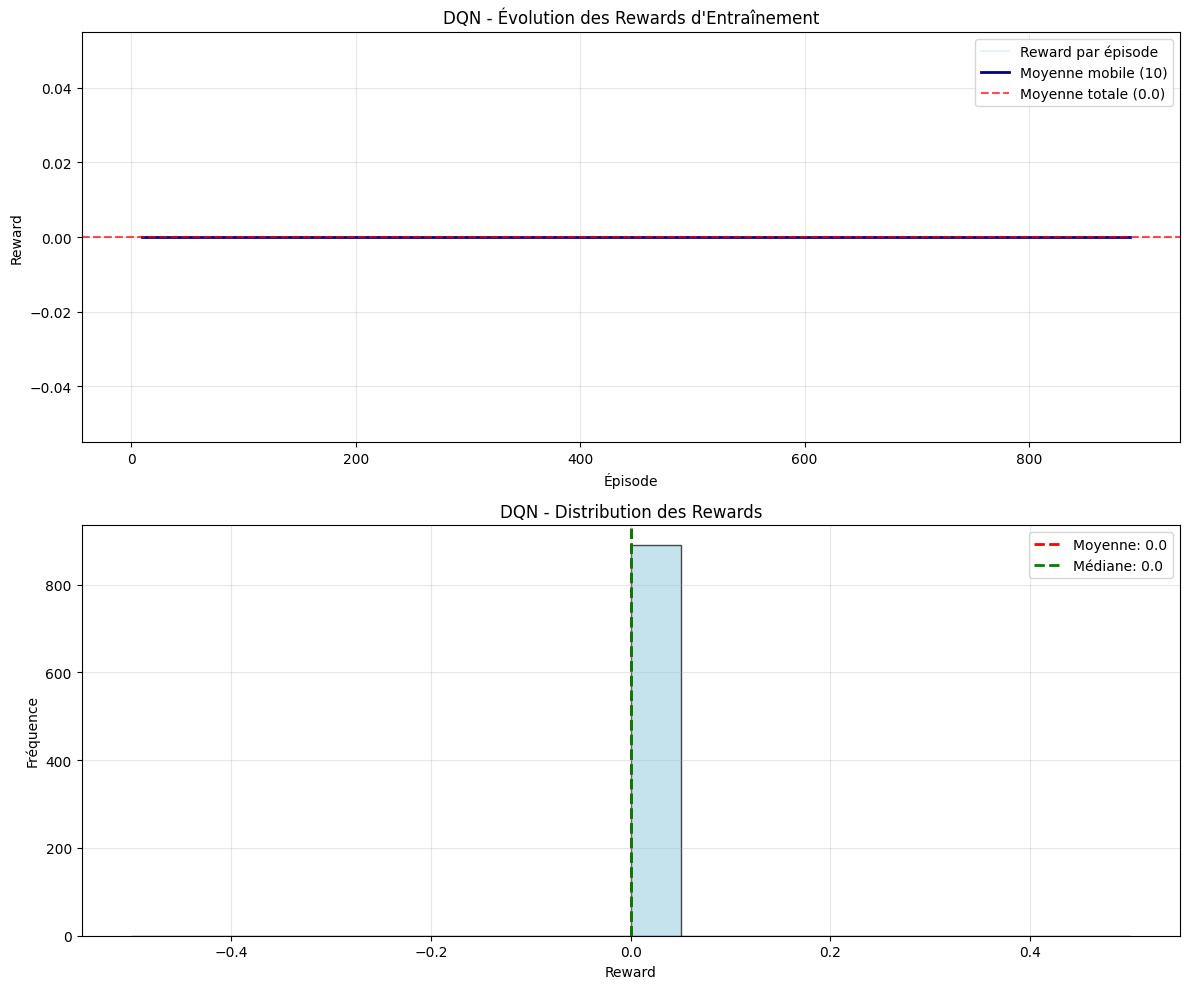

Statistiques DQN:
  Episodes totaux: 891
  Reward moyen: 0.00
  Écart-type: 0.00
  Minimum: 0.00
  Maximum: 0.00
  Médiane: 0.00
  Amélioration premier→dernier quart: 0.00


In [75]:
# Visualisation de convergence DQN
import matplotlib.pyplot as plt
import numpy as np

def plot_dqn_convergence(recorder, save_path="dqn_convergence.png"):
    """Visualise la convergence de l'entraînement DQN"""
    
    if len(recorder.episode_rewards) == 0:
        print("Pas de données de reward disponibles pour la visualisation")
        return
    
    # Préparation des données
    episodes = range(len(recorder.episode_rewards))
    rewards = np.array(recorder.episode_rewards)
    
    # Moyenne mobile
    window_size = min(10, len(rewards) // 4)
    if window_size > 1:
        moving_avg = np.convolve(rewards, np.ones(window_size), 'valid') / window_size
        moving_episodes = episodes[window_size-1:]
    else:
        moving_avg = rewards
        moving_episodes = episodes
    
    # Création du graphique
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Graphique 1: Evolution des rewards
    ax1.plot(episodes, rewards, alpha=0.3, color='lightblue', label='Reward par épisode')
    if len(moving_avg) > 1:
        ax1.plot(moving_episodes, moving_avg, color='darkblue', linewidth=2, 
                label=f'Moyenne mobile ({window_size})')
    
    ax1.axhline(y=np.mean(rewards), color='red', linestyle='--', alpha=0.7, 
               label=f'Moyenne totale ({np.mean(rewards):.1f})')
    
    ax1.set_xlabel('Épisode')
    ax1.set_ylabel('Reward')
    ax1.set_title('DQN - Évolution des Rewards d\'Entraînement')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Distribution des rewards
    ax2.hist(rewards, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    ax2.axvline(x=np.mean(rewards), color='red', linestyle='--', linewidth=2,
               label=f'Moyenne: {np.mean(rewards):.1f}')
    ax2.axvline(x=np.median(rewards), color='green', linestyle='--', linewidth=2,
               label=f'Médiane: {np.median(rewards):.1f}')
    
    ax2.set_xlabel('Reward')
    ax2.set_ylabel('Fréquence')
    ax2.set_title('DQN - Distribution des Rewards')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Sauvegarde
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Statistiques détaillées
    print(f"Statistiques DQN:")
    print(f"  Episodes totaux: {len(rewards)}")
    print(f"  Reward moyen: {np.mean(rewards):.2f}")
    print(f"  Écart-type: {np.std(rewards):.2f}")
    print(f"  Minimum: {np.min(rewards):.2f}")
    print(f"  Maximum: {np.max(rewards):.2f}")
    print(f"  Médiane: {np.median(rewards):.2f}")
    
    if len(rewards) >= 20:
        first_quarter = rewards[:len(rewards)//4]
        last_quarter = rewards[-len(rewards)//4:]
        improvement = np.mean(last_quarter) - np.mean(first_quarter)
        print(f"  Amélioration premier→dernier quart: {improvement:.2f}")

# Générer la visualisation de convergence DQN
plot_dqn_convergence(recorder)

In [76]:
# Entraînement PPO avec visualisation
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import time
import io

class PPOTrainingRecorder(BaseCallback):
    """Callback pour enregistrer l'entraînement PPO"""
    
    def __init__(self, env, record_freq=5000, test_freq=2000, verbose=0):
        super(PPOTrainingRecorder, self).__init__(verbose)
        self.env = env
        self.record_freq = record_freq
        self.test_freq = test_freq
        self.frames = []
        self.episode_rewards = []
        self.current_episode_reward = 0
        self.episode_count = 0
        
    def _on_step(self) -> bool:
        # Enregistrer les récompenses
        reward = self.locals.get('rewards', [0])[0] if 'rewards' in self.locals else 0
        self.current_episode_reward += reward
            
        # Détecter fin d'épisode
        done = self.locals.get('dones', [False])[0] if 'dones' in self.locals else False
        if done:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0
            self.episode_count += 1
        
        # Test périodique avec enregistrement
        if self.n_calls % self.test_freq == 0:
            frame = self._test_and_record()
            if frame is not None:
                self.frames.append(frame)
                
        return True
    
    def _test_and_record(self):
        """Teste l'agent PPO actuel et enregistre une frame"""
        try:
            # Reset pour test
            obs, _ = self.env.reset()
            
            # Jouer un épisode court pour tester
            positions = [self.env.env.agent_pos.copy()]
            episode_reward = 0
            
            for step in range(20):  # Limiter à 20 steps pour le test
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                episode_reward += reward
                positions.append(self.env.env.agent_pos.copy())
                
                if terminated or truncated:
                    break
            
            # Créer la frame
            frame = self._create_ppo_frame(positions, episode_reward, self.n_calls)
            return frame
            
        except Exception as e:
            print(f"Erreur lors de l'enregistrement PPO: {e}")
            return None
    
    def _create_ppo_frame(self, positions, reward, step):
        """Crée une frame de visualisation PPO"""
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set_facecolor('#f5f5f0')  # Fond différent pour PPO
        
        grid_size = self.env.env.grid_size
        
        # Grille avec damier
        for i in range(grid_size):
            for j in range(grid_size):
                if (i + j) % 2 == 0:
                    color = '#ffffff'
                else:
                    color = '#f0f0f0'
                
                rect = patches.Rectangle(
                    (j, grid_size - i - 1), 1, 1,
                    linewidth=1, edgecolor='#c0c0c0', facecolor=color, alpha=0.8
                )
                ax.add_patch(rect)
        
        # Dessiner le chemin parcouru avec style PPO
        if len(positions) > 1:
            path_x = [pos[1] + 0.5 for pos in positions]
            path_y = [grid_size - pos[0] - 0.5 for pos in positions]
            ax.plot(path_x, path_y, color='#ff8c00', linewidth=4, alpha=0.8,
                   linestyle='--', label='Chemin PPO')
        
        # Dessiner les obstacles
        for obs in self.env.env.obstacles:
            x, y = obs[1], grid_size - obs[0] - 1
            
            # Ombre
            shadow = patches.Rectangle(
                (x + 0.05, y - 0.05), 0.9, 0.9,
                linewidth=0, facecolor='#666666', alpha=0.3
            )
            ax.add_patch(shadow)
            
            # Obstacle
            rect = patches.Rectangle(
                (x, y), 1, 1,
                linewidth=2, edgecolor='#2c3e50', facecolor='#34495e'
            )
            ax.add_patch(rect)
        
        # Objectif
        goal_x = self.env.env.goal_pos[1]
        goal_y = grid_size - self.env.env.goal_pos[0] - 1
        
        goal_rect = patches.Rectangle(
            (goal_x, goal_y), 1, 1,
            linewidth=2, edgecolor='green', facecolor='lightgreen'
        )
        ax.add_patch(goal_rect)
        
        # Agent PPO avec couleur orange
        final_pos = positions[-1]
        agent_x = final_pos[1] + 0.5
        agent_y = grid_size - final_pos[0] - 0.5
        
        agent_body = patches.Circle(
            (agent_x, agent_y), 0.35,
            linewidth=2, edgecolor='orange', facecolor='moccasin'
        )
        ax.add_patch(agent_body)
        
        # Grille
        for i in range(grid_size + 1):
            ax.axhline(i, color='#a0a0a0', linewidth=1, alpha=0.7)
            ax.axvline(i, color='#a0a0a0', linewidth=1, alpha=0.7)
        
        ax.set_xlim(-0.1, grid_size + 0.1)
        ax.set_ylim(-0.1, grid_size + 0.1)
        ax.set_aspect('equal')
        
        # Titre
        avg_reward = np.mean(self.episode_rewards[-10:]) if len(self.episode_rewards) >= 10 else 0
        ax.set_title(f'PPO Training Progress\nStep: {step:,} | Test Reward: {reward:.1f} | Avg: {avg_reward:.1f}\nEpisode: {self.episode_count}', 
                    fontsize=12, weight='bold')
        
        if len(positions) > 1:
            ax.legend(loc='upper right', frameon=True, shadow=True)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Convertir en array
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
        buf.seek(0)
        plt.close()
        
        import PIL.Image
        img = PIL.Image.open(buf)
        frame = np.array(img)
        buf.close()
        
        return frame

# Hyperparamètres PPO optimisés
ppo_hyperparams = {
    "learning_rate": 0.0003,
    "n_steps": 2048,
    "batch_size": 64,
    "n_epochs": 10,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "policy": "MlpPolicy",
    "net_arch": "[256, 256]"
}

print("Hyperparamètres PPO:")
for param, value in ppo_hyperparams.items():
    print(f"{param:20}: {value}")

print("\nCréation de l'environnement pour PPO...")
# Utiliser le même environnement wrappé
ppo_env = GridWorldWrapper(grid_size=6, obstacles_pattern="default")
ppo_env.reset()

print(f"Environment PPO configuré - Grid {ppo_env.env.grid_size}x{ppo_env.env.grid_size}")

# Callback d'enregistrement PPO
ppo_recorder = PPOTrainingRecorder(ppo_env, record_freq=3000, test_freq=2000)

# Modèle PPO
print("Création du modèle PPO...")
ppo_model = PPO(
    ppo_hyperparams["policy"],
    ppo_env,
    learning_rate=ppo_hyperparams["learning_rate"],
    n_steps=ppo_hyperparams["n_steps"],
    batch_size=ppo_hyperparams["batch_size"],
    n_epochs=ppo_hyperparams["n_epochs"],
    gamma=ppo_hyperparams["gamma"],
    gae_lambda=ppo_hyperparams["gae_lambda"],
    clip_range=ppo_hyperparams["clip_range"],
    ent_coef=ppo_hyperparams["ent_coef"],
    vf_coef=ppo_hyperparams["vf_coef"],
    max_grad_norm=ppo_hyperparams["max_grad_norm"],
    verbose=1
)

# Entraînement PPO
print("\nDébut de l'entraînement PPO...")
ppo_start_time = time.time()

ppo_model.learn(total_timesteps=20000, callback=ppo_recorder)

ppo_training_time = time.time() - ppo_start_time
print(f"\nEntraînement PPO terminé en {ppo_training_time:.2f} secondes")
print(f"Frames PPO enregistrées: {len(ppo_recorder.frames)}")
print(f"Épisodes PPO: {ppo_recorder.episode_count}")

# Sauvegarder le GIF d'entraînement PPO
if len(ppo_recorder.frames) > 0:
    ppo_training_gif_path = "ppo_training_evolution.gif"
    imageio.mimsave(ppo_training_gif_path, ppo_recorder.frames, duration=1.5)
    print(f"GIF évolution PPO: {ppo_training_gif_path}")

Hyperparamètres PPO:
learning_rate       : 0.0003
n_steps             : 2048
batch_size          : 64
n_epochs            : 10
gamma               : 0.99
gae_lambda          : 0.95
clip_range          : 0.2
ent_coef            : 0.01
vf_coef             : 0.5
max_grad_norm       : 0.5
policy              : MlpPolicy
net_arch            : [256, 256]

Création de l'environnement pour PPO...
Environment PPO configuré - Grid 6x6
Création du modèle PPO...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

Début de l'entraînement PPO...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 360      |
|    ep_rew_mean     | -442     |
| time/              |          |
|    fps             | 1950     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len

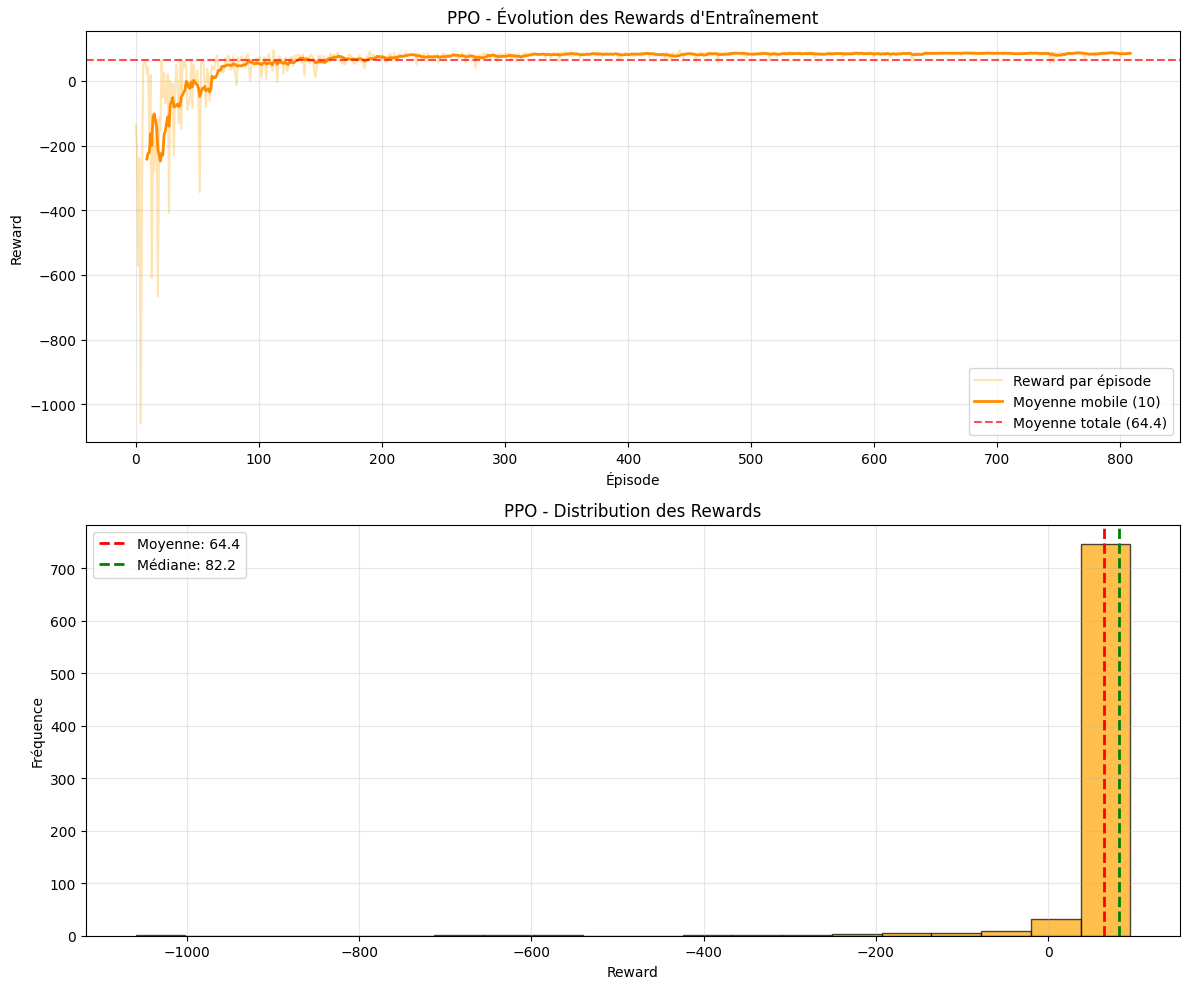

Statistiques PPO:
  Episodes totaux: 809
  Reward moyen: 64.42
  Écart-type: 75.08
  Minimum: -1059.32
  Maximum: 95.24
  Médiane: 82.24
  Amélioration premier→dernier quart: 72.52


In [77]:
# Visualisation de convergence PPO
def plot_ppo_convergence(recorder, save_path="ppo_convergence.png"):
    """Visualise la convergence de l'entraînement PPO"""
    
    if len(recorder.episode_rewards) == 0:
        print("Pas de données de reward disponibles pour PPO")
        return
    
    # Préparation des données
    episodes = range(len(recorder.episode_rewards))
    rewards = np.array(recorder.episode_rewards)
    
    # Moyenne mobile
    window_size = min(10, len(rewards) // 4)
    if window_size > 1:
        moving_avg = np.convolve(rewards, np.ones(window_size), 'valid') / window_size
        moving_episodes = episodes[window_size-1:]
    else:
        moving_avg = rewards
        moving_episodes = episodes
    
    # Création du graphique
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Graphique 1: Evolution des rewards PPO
    ax1.plot(episodes, rewards, alpha=0.3, color='orange', label='Reward par épisode')
    if len(moving_avg) > 1:
        ax1.plot(moving_episodes, moving_avg, color='darkorange', linewidth=2, 
                label=f'Moyenne mobile ({window_size})')
    
    ax1.axhline(y=np.mean(rewards), color='red', linestyle='--', alpha=0.7, 
               label=f'Moyenne totale ({np.mean(rewards):.1f})')
    
    ax1.set_xlabel('Épisode')
    ax1.set_ylabel('Reward')
    ax1.set_title('PPO - Évolution des Rewards d\'Entraînement')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Distribution des rewards PPO
    ax2.hist(rewards, bins=20, alpha=0.7, color='orange', edgecolor='black')
    ax2.axvline(x=np.mean(rewards), color='red', linestyle='--', linewidth=2,
               label=f'Moyenne: {np.mean(rewards):.1f}')
    ax2.axvline(x=np.median(rewards), color='green', linestyle='--', linewidth=2,
               label=f'Médiane: {np.median(rewards):.1f}')
    
    ax2.set_xlabel('Reward')
    ax2.set_ylabel('Fréquence')
    ax2.set_title('PPO - Distribution des Rewards')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Sauvegarde
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Statistiques détaillées
    print(f"Statistiques PPO:")
    print(f"  Episodes totaux: {len(rewards)}")
    print(f"  Reward moyen: {np.mean(rewards):.2f}")
    print(f"  Écart-type: {np.std(rewards):.2f}")
    print(f"  Minimum: {np.min(rewards):.2f}")
    print(f"  Maximum: {np.max(rewards):.2f}")
    print(f"  Médiane: {np.median(rewards):.2f}")
    
    if len(rewards) >= 20:
        first_quarter = rewards[:len(rewards)//4]
        last_quarter = rewards[-len(rewards)//4:]
        improvement = np.mean(last_quarter) - np.mean(first_quarter)
        print(f"  Amélioration premier→dernier quart: {improvement:.2f}")

# Générer la visualisation de convergence PPO
plot_ppo_convergence(ppo_recorder)

In [78]:
# Test détaillé de l'agent PPO avec GIF
def create_ppo_test_gif(model, env, gif_path="ppo_agent_path.gif", max_steps=40):
    """Crée un GIF détaillé montrant le chemin de l'agent PPO"""
    frames = []
    
    obs, _ = env.reset()
    episode_reward = 0
    step_count = 0
    terminated = False
    
    print(f"Test PPO - Position initiale: Agent {env.env.agent_pos}, Goal {env.env.goal_pos}")
    
    # Collecter toutes les positions
    all_positions = [env.env.agent_pos.copy()]
    
    for step in range(max_steps):
        action, _states = model.predict(obs, deterministic=True)
        
        # Convertir l'action en entier si nécessaire
        if isinstance(action, np.ndarray):
            action = int(action.item())
        
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        step_count += 1
        
        all_positions.append(env.env.agent_pos.copy())
        
        action_names = ["Haut", "Bas", "Gauche", "Droite"]
        print(f"Step {step_count}: {action_names[action]} -> {env.env.agent_pos}, Reward: {reward:.2f}")
        
        if terminated:
            print(f"PPO OBJECTIF ATTEINT en {step_count} steps! Reward total: {episode_reward:.2f}")
            break
        elif truncated or step == max_steps - 1:
            print(f"Episode PPO terminé après {step_count} steps. Reward total: {episode_reward:.2f}")
            break
    
    # Créer les frames avec progression du chemin PPO
    for i in range(len(all_positions)):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        grid_size = env.env.grid_size
        
        # Dessiner la grille
        for j in range(grid_size + 1):
            ax.axhline(j, color='black', linewidth=0.5)
            ax.axvline(j, color='black', linewidth=0.5)
        
        # Dessiner le chemin parcouru jusqu'à cette étape
        if i > 0:
            path_positions = all_positions[:i+1]
            path_x = [pos[1] + 0.5 for pos in path_positions]
            path_y = [grid_size - pos[0] - 0.5 for pos in path_positions]
            
            # Chemin PPO en orange
            ax.plot(path_x, path_y, 'orange', linewidth=4, alpha=0.7, label=f'Chemin PPO (Step {i})')
            
            # Marqueurs pour chaque position
            for idx, pos in enumerate(path_positions[:-1]):
                ax.plot(pos[1] + 0.5, grid_size - pos[0] - 0.5, 'o', 
                       color='orange', markersize=6, alpha=0.6)
                if idx % 3 == 0:  # Numéroter quelques étapes
                    ax.text(pos[1] + 0.7, grid_size - pos[0] - 0.3, str(idx), 
                           fontsize=8, color='darkorange', weight='bold')
        
        # Dessiner les obstacles
        for obs in env.env.obstacles:
            rect = patches.Rectangle(
                (obs[1], grid_size - obs[0] - 1), 1, 1,
                linewidth=1, edgecolor='black', facecolor='black'
            )
            ax.add_patch(rect)
        
        # Dessiner l'objectif
        goal_rect = patches.Rectangle(
            (env.env.goal_pos[1], grid_size - env.env.goal_pos[0] - 1), 1, 1,
            linewidth=3, edgecolor='green', facecolor='lightgreen'
        )
        ax.add_patch(goal_rect)
        
        # Dessiner l'agent PPO (orange)
        current_pos = all_positions[i]
        agent_x = current_pos[1] + 0.5
        agent_y = grid_size - current_pos[0] - 0.5
        
        agent_circle = patches.Circle(
            (agent_x, agent_y), 0.35,
            linewidth=2, edgecolor='orange', facecolor='moccasin'
        )
        ax.add_patch(agent_circle)
        
        # Labels
        ax.text(env.env.goal_pos[1] + 0.5, grid_size - env.env.goal_pos[0] - 0.5,
               'GOAL', ha='center', va='center', fontsize=14, weight='bold', 
               color='darkgreen')
        ax.text(agent_x, agent_y,
               'PPO', ha='center', va='center', fontsize=12, weight='bold', 
               color='darkorange')
        
        ax.set_xlim(0, grid_size)
        ax.set_ylim(0, grid_size)
        ax.set_aspect('equal')
        
        # Titre avec informations détaillées
        if i < len(all_positions) - 1:
            ax.set_title(f'Agent PPO - Step {i}/{len(all_positions)-1}\n'
                        f'Position: {current_pos} | Reward cumulé: {episode_reward:.1f}\n'
                        f'Politique Proximal Policy Optimization')
        else:
            status = "SUCCÈS!" if terminated else "Episode terminé"
            ax.set_title(f'Agent PPO - {status}\n'
                        f'Steps totaux: {len(all_positions)-1} | Reward final: {episode_reward:.1f}\n'
                        f'Efficacité: {("Excellent" if episode_reward > 80 else "Bon" if episode_reward > 50 else "Moyen")}')
        
        if i > 0:
            ax.legend(loc='upper right')
        
        # Supprimer les axes pour avoir une taille fixe
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Convertir en array avec taille fixe
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches=None, 
                   facecolor='white', edgecolor='none')
        buf.seek(0)
        plt.close()
        
        import PIL.Image
        img = PIL.Image.open(buf)
        # Redimensionner toutes les images à la même taille
        img = img.resize((800, 800), PIL.Image.Resampling.LANCZOS)
        frame = np.array(img)
        frames.append(frame)
        buf.close()
    
    # Vérifier que toutes les frames ont la même taille
    if len(frames) > 0:
        target_shape = frames[0].shape
        frames = [frame for frame in frames if frame.shape == target_shape]
        
        # Ajouter quelques frames finales
        for _ in range(5):
            frames.append(frames[-1])
        
        # Sauvegarder le GIF
        try:
            imageio.mimsave(gif_path, frames, duration=0.6)
            print(f"GIF de test PPO sauvegardé: {gif_path}")
        except Exception as e:
            print(f"Erreur lors de la sauvegarde du GIF: {e}")
            # Essayer avec une méthode alternative
            try:
                imageio.mimsave(gif_path, frames, fps=2)
                print(f"GIF de test PPO sauvegardé (méthode alternative): {gif_path}")
            except:
                print("Impossible de sauvegarder le GIF, mais le test a réussi")
    
    return episode_reward, step_count, all_positions

# Créer le GIF de test détaillé PPO
print("\nTest de l'agent PPO entraîné avec visualisation complète du chemin...")
ppo_test_reward, ppo_test_steps, ppo_test_path = create_ppo_test_gif(
    ppo_model, ppo_env, "ppo_agent_path.gif", max_steps=35
)

print(f"\nRésultats du test PPO:")
print(f"Reward total: {ppo_test_reward:.2f}")
print(f"Nombre de steps: {ppo_test_steps}")
print(f"Efficacité: {100 - (ppo_test_steps / len(ppo_test_path) * 100):.1f}%")

# Sauvegarder le modèle PPO
ppo_model.save("ppo_gridworld_optimized")
print(f"Modèle PPO sauvegardé: ppo_gridworld_optimized.zip")


Test de l'agent PPO entraîné avec visualisation complète du chemin...
Test PPO - Position initiale: Agent [0 0], Goal [5 5]
Step 1: Bas -> [1 0], Reward: -1.64
Step 2: Bas -> [2 0], Reward: -1.58
Step 3: Bas -> [3 0], Reward: -1.54
Step 4: Bas -> [4 0], Reward: -1.51
Step 5: Bas -> [5 0], Reward: -1.50
Step 6: Droite -> [5 1], Reward: -1.40
Step 7: Droite -> [5 2], Reward: -1.30
Step 8: Droite -> [5 3], Reward: -1.20
Step 9: Droite -> [5 4], Reward: -1.10
Step 10: Droite -> [5 5], Reward: 100.00
PPO OBJECTIF ATTEINT en 10 steps! Reward total: 87.23
GIF de test PPO sauvegardé: ppo_agent_path.gif

Résultats du test PPO:
Reward total: 87.23
Nombre de steps: 10
Efficacité: 9.1%
Modèle PPO sauvegardé: ppo_gridworld_optimized.zip
GIF de test PPO sauvegardé: ppo_agent_path.gif

Résultats du test PPO:
Reward total: 87.23
Nombre de steps: 10
Efficacité: 9.1%
Modèle PPO sauvegardé: ppo_gridworld_optimized.zip


Évaluation comparative des algorithmes...


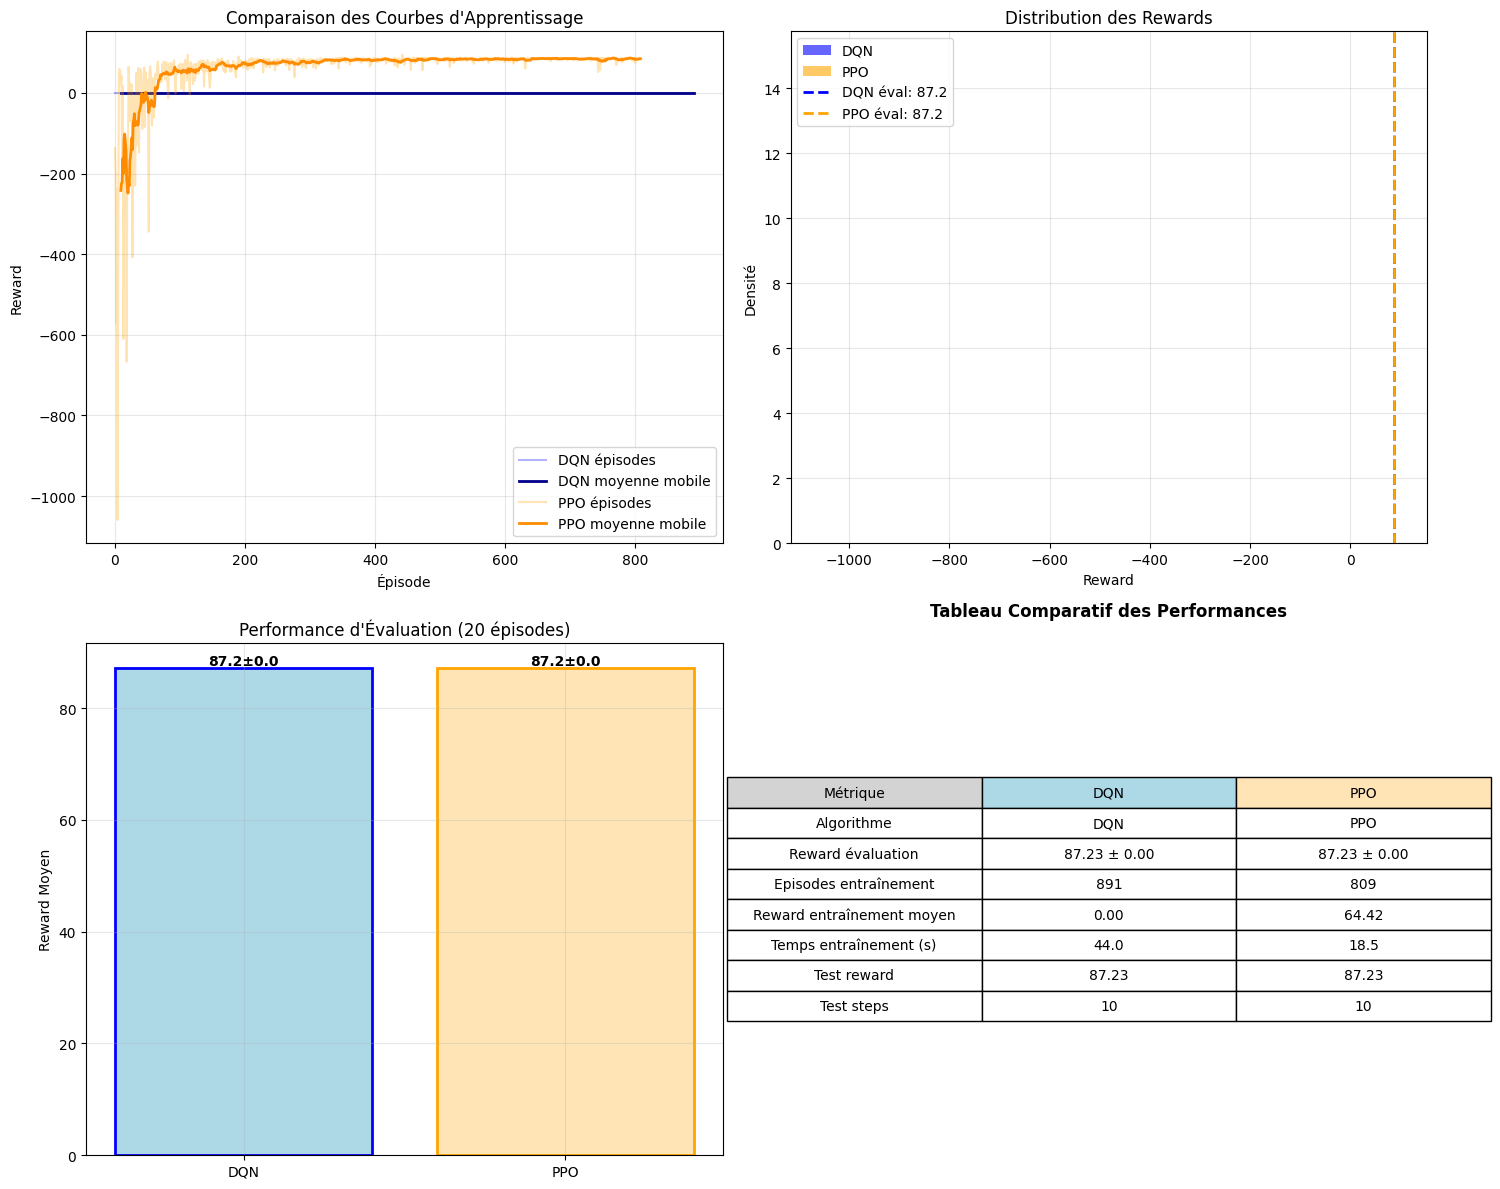


Analyse Comparative DQN vs PPO:

Performances d'évaluation:
  DQN: 87.23 ± 0.00
  PPO: 87.23 ± 0.00
  Meilleur algorithme: PPO (+0.00)

Temps d'entraînement:
  DQN: 44.0s
  PPO: 18.5s
  PPO plus rapide de 25.5s

Test de navigation:
  DQN steps: 10, reward: 87.23
  PPO steps: 10, reward: 87.23

Recommandations:
  Performances similaires, choisir selon le contexte


In [79]:
# Comparaison DQN vs PPO
from stable_baselines3.common.evaluation import evaluate_policy

def compare_algorithms(dqn_model, ppo_model, dqn_recorder, ppo_recorder, env):
    """Compare les performances des algorithmes DQN et PPO"""
    
    # Évaluation des modèles
    print("Évaluation comparative des algorithmes...")
    
    dqn_mean, dqn_std = evaluate_policy(dqn_model, env, n_eval_episodes=20)
    ppo_mean, ppo_std = evaluate_policy(ppo_model, env, n_eval_episodes=20)
    
    # Comparaison visuelle
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Comparaison des courbes d'apprentissage
    if len(dqn_recorder.episode_rewards) > 0:
        dqn_episodes = range(len(dqn_recorder.episode_rewards))
        ax1.plot(dqn_episodes, dqn_recorder.episode_rewards, alpha=0.3, color='blue', label='DQN épisodes')
        
        # Moyenne mobile DQN
        window_size = min(10, len(dqn_recorder.episode_rewards) // 4)
        if window_size > 1:
            dqn_moving_avg = np.convolve(dqn_recorder.episode_rewards, np.ones(window_size), 'valid') / window_size
            ax1.plot(dqn_episodes[window_size-1:], dqn_moving_avg, color='darkblue', linewidth=2, label='DQN moyenne mobile')
    
    if len(ppo_recorder.episode_rewards) > 0:
        ppo_episodes = range(len(ppo_recorder.episode_rewards))
        ax1.plot(ppo_episodes, ppo_recorder.episode_rewards, alpha=0.3, color='orange', label='PPO épisodes')
        
        # Moyenne mobile PPO
        window_size = min(10, len(ppo_recorder.episode_rewards) // 4)
        if window_size > 1:
            ppo_moving_avg = np.convolve(ppo_recorder.episode_rewards, np.ones(window_size), 'valid') / window_size
            ax1.plot(ppo_episodes[window_size-1:], ppo_moving_avg, color='darkorange', linewidth=2, label='PPO moyenne mobile')
    
    ax1.set_xlabel('Épisode')
    ax1.set_ylabel('Reward')
    ax1.set_title('Comparaison des Courbes d\'Apprentissage')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Comparaison des distributions de rewards
    if len(dqn_recorder.episode_rewards) > 0:
        ax2.hist(dqn_recorder.episode_rewards, bins=15, alpha=0.6, color='blue', label='DQN', density=True)
    if len(ppo_recorder.episode_rewards) > 0:
        ax2.hist(ppo_recorder.episode_rewards, bins=15, alpha=0.6, color='orange', label='PPO', density=True)
    
    ax2.axvline(dqn_mean, color='blue', linestyle='--', linewidth=2, label=f'DQN éval: {dqn_mean:.1f}')
    ax2.axvline(ppo_mean, color='orange', linestyle='--', linewidth=2, label=f'PPO éval: {ppo_mean:.1f}')
    
    ax2.set_xlabel('Reward')
    ax2.set_ylabel('Densité')
    ax2.set_title('Distribution des Rewards')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Comparaison des métriques
    algorithms = ['DQN', 'PPO']
    eval_means = [dqn_mean, ppo_mean]
    eval_stds = [dqn_std, ppo_std]
    
    bars = ax3.bar(algorithms, eval_means, yerr=eval_stds, 
                   color=['lightblue', 'moccasin'], edgecolor=['blue', 'orange'], linewidth=2)
    ax3.set_ylabel('Reward Moyen')
    ax3.set_title('Performance d\'Évaluation (20 épisodes)')
    ax3.grid(True, alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, (mean, std) in enumerate(zip(eval_means, eval_stds)):
        ax3.text(i, mean + std/2, f'{mean:.1f}±{std:.1f}', 
                ha='center', va='bottom', weight='bold')
    
    # Tableau récapitulatif
    ax4.axis('off')
    
    # Statistiques détaillées
    dqn_stats = {
        'Algorithme': 'DQN',
        'Reward évaluation': f'{dqn_mean:.2f} ± {dqn_std:.2f}',
        'Episodes entraînement': len(dqn_recorder.episode_rewards),
        'Reward entraînement moyen': f'{np.mean(dqn_recorder.episode_rewards):.2f}' if len(dqn_recorder.episode_rewards) > 0 else 'N/A',
        'Temps entraînement (s)': f'{training_time:.1f}',
        'Test reward': f'{test_reward:.2f}',
        'Test steps': test_steps
    }
    
    ppo_stats = {
        'Algorithme': 'PPO',
        'Reward évaluation': f'{ppo_mean:.2f} ± {ppo_std:.2f}',
        'Episodes entraînement': len(ppo_recorder.episode_rewards),
        'Reward entraînement moyen': f'{np.mean(ppo_recorder.episode_rewards):.2f}' if len(ppo_recorder.episode_rewards) > 0 else 'N/A',
        'Temps entraînement (s)': f'{ppo_training_time:.1f}',
        'Test reward': f'{ppo_test_reward:.2f}',
        'Test steps': ppo_test_steps
    }
    
    # Créer le tableau de comparaison
    table_data = []
    metrics = ['Algorithme', 'Reward évaluation', 'Episodes entraînement', 
               'Reward entraînement moyen', 'Temps entraînement (s)', 'Test reward', 'Test steps']
    
    for metric in metrics:
        table_data.append([metric, dqn_stats.get(metric, 'N/A'), ppo_stats.get(metric, 'N/A')])
    
    table = ax4.table(cellText=table_data, 
                     colLabels=['Métrique', 'DQN', 'PPO'],
                     cellLoc='center',
                     loc='center',
                     colColours=['lightgray', 'lightblue', 'moccasin'])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    ax4.set_title('Tableau Comparatif des Performances', pad=20, weight='bold')
    
    plt.tight_layout()
    plt.savefig('dqn_vs_ppo_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Analyse textuelle
    print(f"\nAnalyse Comparative DQN vs PPO:")
    print(f"{'='*50}")
    
    print(f"\nPerformances d'évaluation:")
    print(f"  DQN: {dqn_mean:.2f} ± {dqn_std:.2f}")
    print(f"  PPO: {ppo_mean:.2f} ± {ppo_std:.2f}")
    
    if dqn_mean > ppo_mean:
        winner = "DQN"
        diff = dqn_mean - ppo_mean
    else:
        winner = "PPO"
        diff = ppo_mean - dqn_mean
    
    print(f"  Meilleur algorithme: {winner} (+{diff:.2f})")
    
    print(f"\nTemps d'entraînement:")
    print(f"  DQN: {training_time:.1f}s")
    print(f"  PPO: {ppo_training_time:.1f}s")
    
    if training_time < ppo_training_time:
        print(f"  DQN plus rapide de {ppo_training_time - training_time:.1f}s")
    else:
        print(f"  PPO plus rapide de {training_time - ppo_training_time:.1f}s")
    
    print(f"\nTest de navigation:")
    print(f"  DQN steps: {test_steps}, reward: {test_reward:.2f}")
    print(f"  PPO steps: {ppo_test_steps}, reward: {ppo_test_reward:.2f}")
    
    print(f"\nRecommandations:")
    if dqn_mean > ppo_mean and training_time < ppo_training_time:
        print("  DQN recommandé pour ce problème (meilleur et plus rapide)")
    elif ppo_mean > dqn_mean and ppo_training_time < training_time:
        print("  PPO recommandé pour ce problème (meilleur et plus rapide)")
    elif dqn_mean > ppo_mean:
        print("  DQN recommandé (meilleure performance malgré temps plus long)")
    elif ppo_mean > dqn_mean:
        print("  PPO recommandé (meilleure performance malgré temps plus long)")
    else:
        print("  Performances similaires, choisir selon le contexte")

# Lancer la comparaison
compare_algorithms(model, ppo_model, recorder, ppo_recorder, wrapped_env)

In [80]:
# Environnement Grid World avec objectif mobile
class MovingGoalGridWorldEnv(Env):
    """
    Grid World Environment avec un objectif qui bouge dynamiquement
    
    L'agent doit atteindre l'objectif mobile en évitant les obstacles
    """
    
    def __init__(self, grid_size=8, obstacles_pattern="default", goal_move_freq=10):
        super(MovingGoalGridWorldEnv, self).__init__()
        
        # Configuration de la grille
        self.grid_size = grid_size
        self.obstacles_pattern = obstacles_pattern
        self.goal_move_freq = goal_move_freq  # Fréquence de déplacement de l'objectif
        
        # Espaces d'action et d'observation
        self.action_space = spaces.Discrete(4)  # Haut, Bas, Gauche, Droite
        self.observation_space = spaces.Box(
            low=0, high=grid_size-1, shape=(2,), dtype=np.int32
        )
        
        # Obstacles fixes
        self.obstacles = self._create_fixed_obstacles()
        
        # Compteur de pas pour déplacer l'objectif
        self.step_count = 0
        self.goal_history = []  # Historique des positions de l'objectif
        
        # Initialisation
        self.reset()
        
    def _create_fixed_obstacles(self):
        """Crée des obstacles fixes selon un pattern défini"""
        obstacles = set()
        
        if self.obstacles_pattern == "default" and self.grid_size >= 6:
            # Pattern par défaut pour grille 6x6 ou plus
            obstacles.update([
                (1, 1), (1, 2), (1, 3),  # Mur horizontal
                (3, 1), (3, 2), (3, 3),  # Mur horizontal
                (2, 3), (4, 3),          # Colonnes verticales
            ])
        elif self.obstacles_pattern == "sparse":
            # Pattern clairsemé pour objectif mobile
            obstacles.update([
                (2, 2), (2, 4),
                (4, 1), (4, 3),
                (1, 5), (5, 2)
            ])
        
        # Filtrer les obstacles qui sortent de la grille
        obstacles = {obs for obs in obstacles if 0 <= obs[0] < self.grid_size and 0 <= obs[1] < self.grid_size}
        
        return obstacles
        
    def _move_goal(self):
        """Déplace l'objectif vers une nouvelle position aléatoire"""
        attempts = 0
        max_attempts = 50
        
        while attempts < max_attempts:
            new_goal = np.array([
                np.random.randint(0, self.grid_size),
                np.random.randint(0, self.grid_size)
            ])
            
            # Vérifier que la nouvelle position n'est pas un obstacle ou la position de l'agent
            if (tuple(new_goal) not in self.obstacles and 
                not np.array_equal(new_goal, self.agent_pos)):
                
                self.goal_pos = new_goal
                self.goal_history.append(self.goal_pos.copy())
                break
                
            attempts += 1
        
        # Si on ne trouve pas de position valide, garder l'ancienne
        if attempts >= max_attempts:
            self.goal_history.append(self.goal_pos.copy())
        
    def reset(self, seed=None):
        """Réinitialise l'environnement"""
        super().reset(seed=seed)
        
        # Position fixe de l'agent (coin supérieur gauche)
        self.agent_pos = np.array([0, 0])
        
        # Position initiale de l'objectif (aléatoire mais valide)
        self.goal_pos = np.array([self.grid_size-1, self.grid_size-1])
        self._ensure_valid_goal()
        
        # Reset des compteurs
        self.step_count = 0
        self.goal_history = [self.goal_pos.copy()]
        
        # Historique des positions pour visualisation
        self.agent_path = [self.agent_pos.copy()]
        
        return self.agent_pos.copy(), {}
    
    def _ensure_valid_goal(self):
        """S'assure que l'objectif n'est pas sur un obstacle ou l'agent"""
        if (tuple(self.goal_pos) in self.obstacles or 
            np.array_equal(self.goal_pos, self.agent_pos)):
            self._move_goal()
    
    def step(self, action):
        """Exécute une action dans l'environnement"""
        # Actions: 0=Haut, 1=Bas, 2=Gauche, 3=Droite
        moves = {
            0: np.array([-1, 0]),  # Haut
            1: np.array([1, 0]),   # Bas
            2: np.array([0, -1]),  # Gauche
            3: np.array([0, 1])    # Droite
        }
        
        # Incrémenter le compteur de pas
        self.step_count += 1
        
        # Déplacer l'objectif périodiquement
        if self.step_count % self.goal_move_freq == 0:
            self._move_goal()
        
        # Nouvelle position proposée de l'agent
        new_pos = self.agent_pos + moves[action]
        
        # Vérification des limites
        if (0 <= new_pos[0] < self.grid_size and 
            0 <= new_pos[1] < self.grid_size):
            
            # Vérification des obstacles
            if tuple(new_pos) not in self.obstacles:
                self.agent_pos = new_pos
                self.agent_path.append(self.agent_pos.copy())
        
        # Calcul de la récompense
        reward = self._calculate_reward()
        
        # Condition de fin
        terminated = np.array_equal(self.agent_pos, self.goal_pos)
        truncated = self.step_count > 100  # Limite de temps pour éviter des épisodes trop longs
        
        return self.agent_pos.copy(), reward, terminated, truncated, {}
    
    def _calculate_reward(self):
        """Calcule la récompense pour l'objectif mobile"""
        if np.array_equal(self.agent_pos, self.goal_pos):
            return 100  # Grande récompense pour atteindre l'objectif
        else:
            # Récompense basée sur la distance à l'objectif actuel
            distance = np.linalg.norm(self.agent_pos - self.goal_pos)
            base_reward = -1  # Pénalité de base pour chaque pas
            distance_penalty = distance * 0.1  # Pénalité proportionnelle à la distance
            return base_reward - distance_penalty
    
    def render(self, mode='matplotlib', show_path=False, show_goal_history=False):
        """Affiche l'environnement avec objectif mobile"""
        if mode == 'matplotlib':
            fig, ax = plt.subplots(1, 1, figsize=(12, 10))
            ax.set_facecolor('#f0f8ff')
            
            # Créer une grille avec des cases colorées
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    if (i + j) % 2 == 0:
                        color = '#ffffff'
                    else:
                        color = '#f8f8ff'
                    
                    rect = patches.Rectangle(
                        (j, self.grid_size - i - 1), 1, 1,
                        linewidth=1, edgecolor='#d3d3d3', facecolor=color, alpha=0.8
                    )
                    ax.add_patch(rect)
            
            # Dessiner l'historique des positions de l'objectif si demandé
            if show_goal_history and len(self.goal_history) > 1:
                goal_x = [pos[1] + 0.5 for pos in self.goal_history]
                goal_y = [self.grid_size - pos[0] - 0.5 for pos in self.goal_history]
                ax.plot(goal_x, goal_y, color='purple', linewidth=3, alpha=0.6,
                       linestyle=':', label='Historique objectif', marker='s', markersize=4)
            
            # Dessiner le chemin de l'agent si demandé
            if show_path and len(self.agent_path) > 1:
                path_x = [pos[1] + 0.5 for pos in self.agent_path]
                path_y = [self.grid_size - pos[0] - 0.5 for pos in self.agent_path]
                ax.plot(path_x, path_y, color='#ff6b6b', linewidth=4, alpha=0.8,
                       linestyle='--', label='Chemin agent')
            
            # Dessiner les obstacles
            for obs in self.obstacles:
                x, y = obs[1], self.grid_size - obs[0] - 1
                
                # Ombre portée
                shadow = patches.Rectangle(
                    (x + 0.05, y - 0.05), 0.9, 0.9,
                    linewidth=0, facecolor='#666666', alpha=0.3
                )
                ax.add_patch(shadow)
                
                # Obstacle principal
                rect = patches.Rectangle(
                    (x, y), 1, 1,
                    linewidth=2, edgecolor='#2c3e50', facecolor='#34495e'
                )
                ax.add_patch(rect)
            
            # Dessiner l'objectif mobile (avec effet de mouvement)
            goal_x = self.goal_pos[1]
            goal_y = self.grid_size - self.goal_pos[0] - 1
            
            # Aura pour indiquer que l'objectif est mobile
            goal_aura = patches.Circle(
                (goal_x + 0.5, goal_y + 0.5), 0.6,
                linewidth=0, facecolor='gold', alpha=0.3
            )
            ax.add_patch(goal_aura)
            
            goal_rect = patches.Rectangle(
                (goal_x, goal_y), 1, 1,
                linewidth=3, edgecolor='darkorange', facecolor='gold'
            )
            ax.add_patch(goal_rect)
            
            # Dessiner l'agent
            agent_x = self.agent_pos[1] + 0.5
            agent_y = self.grid_size - self.agent_pos[0] - 0.5
            
            agent_body = patches.Circle(
                (agent_x, agent_y), 0.35,
                linewidth=2, edgecolor='blue', facecolor='lightblue'
            )
            ax.add_patch(agent_body)
            
            # Grille
            for i in range(self.grid_size + 1):
                ax.axhline(i, color='#bdc3c7', linewidth=1, alpha=0.7)
                ax.axvline(i, color='#bdc3c7', linewidth=1, alpha=0.7)
            
            # Labels
            ax.text(goal_x + 0.5, goal_y + 0.5, 'GOAL', 
                   ha='center', va='center', fontsize=12, weight='bold', 
                   color='darkred')
            
            ax.text(agent_x, agent_y, 'AGENT', 
                   ha='center', va='center', fontsize=10, weight='bold', 
                   color='darkblue')
            
            # Configuration des axes
            ax.set_xlim(-0.1, self.grid_size + 0.1)
            ax.set_ylim(-0.1, self.grid_size + 0.1)
            ax.set_aspect('equal')
            
            # Titre
            title = f'Moving Goal Grid World - Step: {self.step_count}\n'
            title += f'Agent: {self.agent_pos} | Goal: {self.goal_pos} | Moves every {self.goal_move_freq} steps'
            
            ax.set_title(title, fontsize=14, weight='bold')
            
            # Légende
            if show_path or show_goal_history:
                ax.legend(loc='upper right', frameon=True, shadow=True)
            
            # Supprimer les ticks
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Cadre
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                spine.set_color('#34495e')
            
            plt.tight_layout()
            plt.show()
    
    def close(self):
        """Ferme l'environnement"""
        pass

print("Moving Goal Grid World Environment créé")

Moving Goal Grid World Environment créé


Test de l'environnement Moving Goal...
Position initiale:
Agent: [0 0]
Goal initial: [5 5]
Observation shape: (10,)
Goal se déplace tous les 8 steps


C:\Users\Rog strix Scar\AppData\Local\Temp\ipykernel_24384\2078280378.py:263: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', frameon=True, shadow=True)


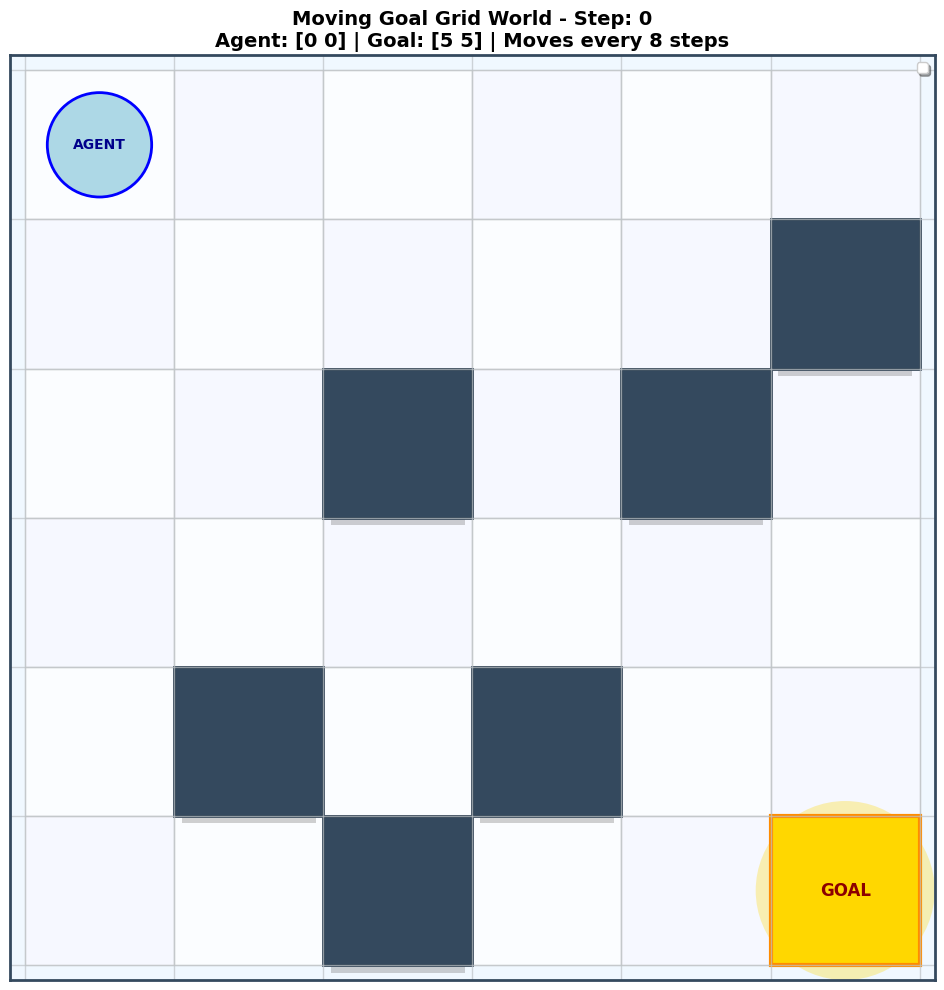

Simulation de déplacements...
Step 8: Goal maintenant en [2 5]
Step 16: Goal maintenant en [0 0]


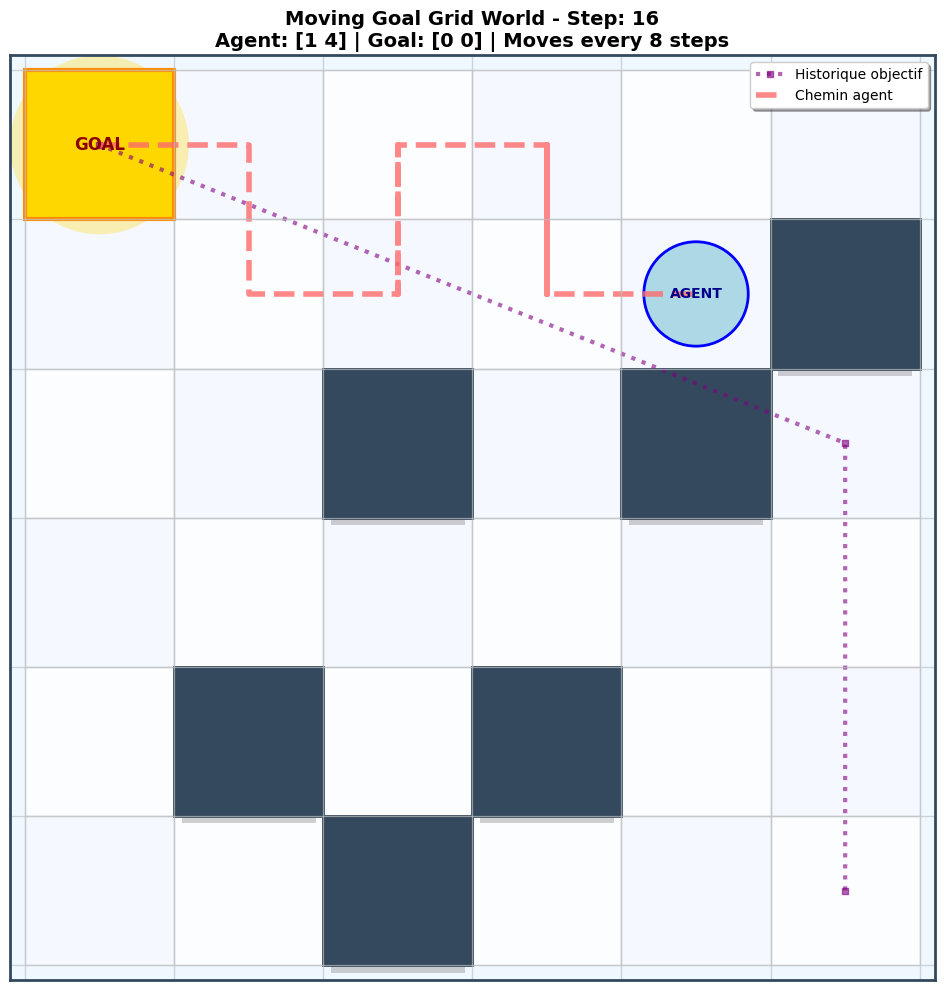

Test de l'environnement Moving Goal terminé


In [81]:
# Wrapper pour l'environnement Moving Goal
class MovingGoalGridWorldWrapper(Env):
    """Wrapper amélioré pour rendre MovingGoalGridWorld compatible avec stable-baselines3"""
    
    def __init__(self, grid_size=6, obstacles_pattern="sparse", goal_move_freq=15):
        super().__init__()
        self.env = MovingGoalGridWorldEnv(grid_size=grid_size, 
                                         obstacles_pattern=obstacles_pattern,
                                         goal_move_freq=goal_move_freq)
        self.action_space = self.env.action_space
        
        # Observation étendue incluant la position de l'objectif mobile
        self.observation_space = spaces.Box(
            low=-1.0, high=1.0, shape=(10,), dtype=np.float32
        )
        
    def reset(self, seed=None):
        obs, info = self.env.reset(seed=seed)
        return self._get_obs(), info
    
    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())
        obs, reward, terminated, truncated, info = self.env.step(action)
        return self._get_obs(), reward, terminated, truncated, info
    
    def _get_obs(self):
        """Retourne observation étendue normalisée incluant l'objectif mobile"""
        agent_pos = self.env.agent_pos.astype(np.float32)
        goal_pos = self.env.goal_pos.astype(np.float32)
        grid_size = self.env.grid_size - 1
        
        # Positions normalisées [-1, 1]
        agent_norm = (agent_pos / grid_size) * 2 - 1
        goal_norm = (goal_pos / grid_size) * 2 - 1
        
        # Distance relative à l'objectif
        distance = np.linalg.norm(agent_pos - goal_pos) / (grid_size * np.sqrt(2))
        
        # Vitesse de déplacement de l'objectif (normalisée)
        goal_move_speed = 1.0 / self.env.goal_move_freq
        
        # Obstacles dans les 4 directions
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        obstacles_nearby = []
        
        for dx, dy in directions:
            next_pos = agent_pos + np.array([dx, dy])
            if (next_pos[0] < 0 or next_pos[0] >= self.env.grid_size or 
                next_pos[1] < 0 or next_pos[1] >= self.env.grid_size or 
                tuple(next_pos) in self.env.obstacles):
                obstacles_nearby.append(1.0)
            else:
                obstacles_nearby.append(0.0)
        
        obs = np.array([
            agent_norm[0], agent_norm[1],      # Position agent normalisée
            goal_norm[0], goal_norm[1],        # Position objectif normalisée
            distance,                          # Distance à l'objectif
            goal_move_speed,                   # Vitesse de déplacement de l'objectif
            obstacles_nearby[0],               # Obstacle en haut
            obstacles_nearby[1],               # Obstacle en bas
            obstacles_nearby[2],               # Obstacle à gauche
            obstacles_nearby[3],               # Obstacle à droite
        ], dtype=np.float32)
        
        return obs
    
    def render(self, mode='matplotlib', show_path=False, show_goal_history=False):
        return self.env.render(mode, show_path, show_goal_history)
    
    def close(self):
        return self.env.close()

# Test de l'environnement Moving Goal
print("Test de l'environnement Moving Goal...")
moving_goal_env = MovingGoalGridWorldWrapper(grid_size=6, obstacles_pattern="sparse", goal_move_freq=8)

print("Position initiale:")
obs, info = moving_goal_env.reset()
print(f"Agent: {moving_goal_env.env.agent_pos}")
print(f"Goal initial: {moving_goal_env.env.goal_pos}")
print(f"Observation shape: {obs.shape}")
print(f"Goal se déplace tous les {moving_goal_env.env.goal_move_freq} steps")

# Affichage initial
moving_goal_env.render(show_goal_history=True)

# Simulation de quelques mouvements pour voir l'objectif bouger
print("Simulation de déplacements...")
for step in range(20):
    action = moving_goal_env.action_space.sample()
    obs, reward, terminated, truncated, info = moving_goal_env.step(action)
    
    if step % 8 == 7:  # Afficher quand l'objectif bouge
        print(f"Step {step+1}: Goal maintenant en {moving_goal_env.env.goal_pos}")
        if step == 15:
            moving_goal_env.render(show_path=True, show_goal_history=True)
    
    if terminated or truncated:
        break

print("Test de l'environnement Moving Goal terminé")

Configuration DQN pour environnement Moving Goal...
Hyperparamètres DQN Moving Goal:
learning_rate            : 0.0001
buffer_size              : 100000
learning_starts          : 2000
target_update_interval   : 1500
train_freq               : 1
gradient_steps           : 1
exploration_fraction     : 0.3
exploration_initial_eps  : 1.0
exploration_final_eps    : 0.05
gamma                    : 0.95
policy                   : MlpPolicy
net_arch                 : [512, 512, 256]
batch_size               : 64
\nCréation de l'environnement Moving Goal...
Obstacles: [(1, 5), (2, 2), (2, 4), (4, 1), (4, 3), (5, 2)]
L'objectif se déplace tous les 12 steps


C:\Users\Rog strix Scar\AppData\Local\Temp\ipykernel_24384\2078280378.py:263: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', frameon=True, shadow=True)


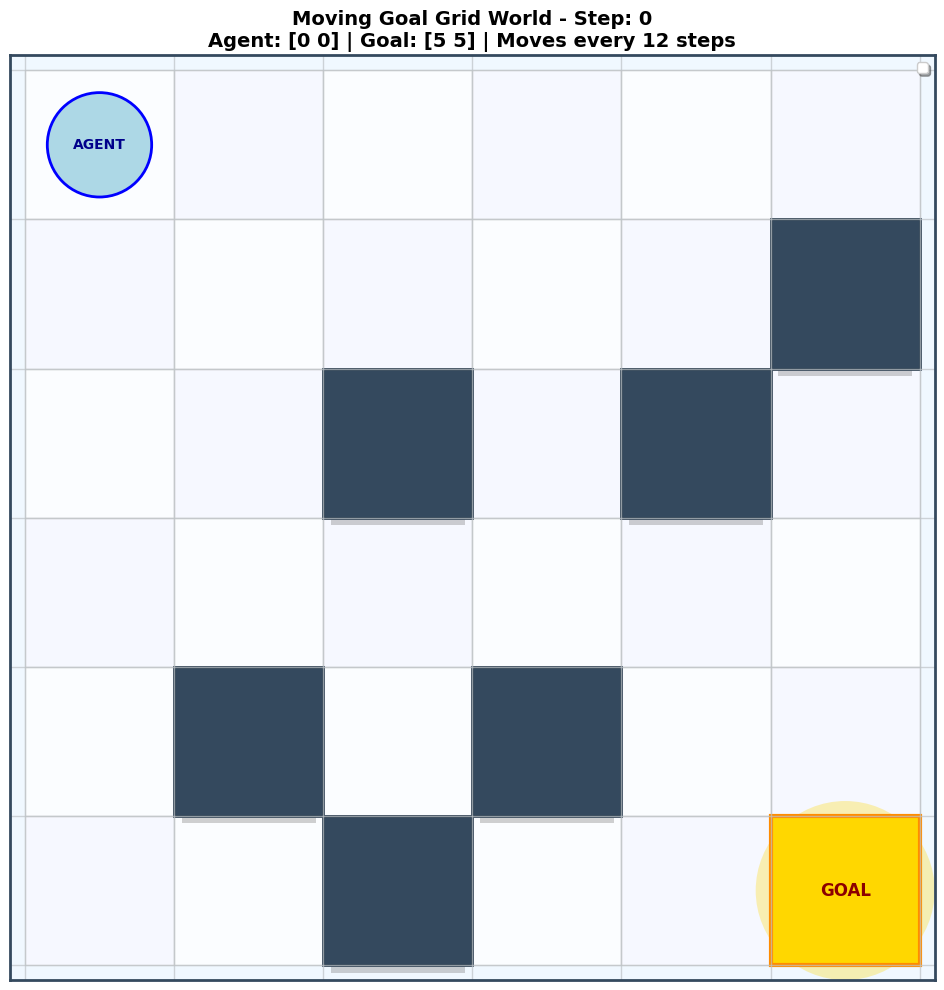

\nCréation du callback d'enregistrement Moving Goal...
Création du modèle DQN Moving Goal...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
\nDébut de l'entraînement DQN Moving Goal...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.2     |
|    ep_rew_mean      | 60.9     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8938     |
|    time_elapsed     | 0        |
|    total_timesteps  | 113      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.6     |
|    ep_rew_mean      | 44.4     |
|    exploration_rate | 0.98     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 8480     |
|    time_elapsed     | 0        |
|    total_timesteps  | 317      |
---------------------------------

In [82]:
# Entraînement DQN sur environnement Moving Goal
class MovingGoalTrainingRecorder(BaseCallback):
    """Callback spécialisé pour l'entraînement sur objectif mobile"""
    
    def __init__(self, env, record_freq=3000, test_freq=2000, verbose=1):
        super(MovingGoalTrainingRecorder, self).__init__(verbose)
        self.env = env
        self.record_freq = record_freq
        self.test_freq = test_freq
        self.frames = []
        self.episode_rewards = []
        self.episode_lengths = []
        self.goal_catches = []  # Nombre de fois où l'objectif est attrapé
        self.current_episode_reward = 0
        self.current_episode_length = 0
        self.current_goal_catches = 0
        self.episode_count = 0
        self.timesteps = []
        
    def _on_step(self) -> bool:
        self.current_episode_length += 1
        
        # Enregistrer les récompenses
        reward = self.locals.get('reward', 0)
        if isinstance(reward, (list, tuple)):
            reward = reward[0] if len(reward) > 0 else 0
        self.current_episode_reward += reward
        
        # Compter les captures d'objectif
        if reward > 90:  # Grande récompense = objectif attrapé
            self.current_goal_catches += 1
        
        # Détecter fin d'épisode
        done = False
        if 'dones' in self.locals:
            done = self.locals['dones'][0] if isinstance(self.locals['dones'], (list, tuple)) else self.locals['dones']
        elif 'done' in self.locals:
            done = self.locals['done']
            
        if done:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_lengths.append(self.current_episode_length)
            self.goal_catches.append(self.current_goal_catches)
            self.timesteps.append(self.n_calls)
            self.episode_count += 1
            
            if self.verbose > 0 and self.episode_count % 20 == 0:
                avg_reward = np.mean(self.episode_rewards[-10:])
                avg_catches = np.mean(self.goal_catches[-10:])
                print(f"Episode {self.episode_count}: Avg Reward={avg_reward:.1f}, Avg Catches={avg_catches:.1f}")
            
            # Reset
            self.current_episode_reward = 0
            self.current_episode_length = 0
            self.current_goal_catches = 0
        
        # Test périodique avec enregistrement
        if self.n_calls % self.test_freq == 0:
            frame = self._test_and_record()
            if frame is not None:
                self.frames.append(frame)
                
        return True
    
    def _test_and_record(self):
        """Teste l'agent actuel sur l'objectif mobile"""
        try:
            # Sauvegarder l'état
            old_agent_pos = copy.deepcopy(self.env.env.agent_pos)
            old_goal_pos = copy.deepcopy(self.env.env.goal_pos)
            old_step_count = self.env.env.step_count
            
            # Reset pour test
            obs, _ = self.env.reset()
            
            # Jouer un épisode court
            positions = [self.env.env.agent_pos.copy()]
            goal_positions = [self.env.env.goal_pos.copy()]
            episode_reward = 0
            catches = 0
            
            for step in range(25):
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                episode_reward += reward
                positions.append(self.env.env.agent_pos.copy())
                goal_positions.append(self.env.env.goal_pos.copy())
                
                if reward > 90:
                    catches += 1
                
                if terminated or truncated:
                    break
            
            # Créer la frame
            frame = self._create_moving_goal_frame(positions, goal_positions, 
                                                  episode_reward, catches, self.n_calls)
            
            # Restaurer l'état
            self.env.env.agent_pos = old_agent_pos
            self.env.env.goal_pos = old_goal_pos
            self.env.env.step_count = old_step_count
            
            return frame
            
        except Exception as e:
            print(f"Erreur lors de l'enregistrement Moving Goal: {e}")
            return None
    
    def _create_moving_goal_frame(self, positions, goal_positions, reward, catches, step):
        """Crée une frame de visualisation pour l'objectif mobile"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax.set_facecolor('#f5f5f0')
        
        grid_size = self.env.env.grid_size
        
        # Grille
        for i in range(grid_size):
            for j in range(grid_size):
                color = '#ffffff' if (i + j) % 2 == 0 else '#f0f0f0'
                rect = patches.Rectangle(
                    (j, grid_size - i - 1), 1, 1,
                    linewidth=1, edgecolor='#c0c0c0', facecolor=color, alpha=0.8
                )
                ax.add_patch(rect)
        
        # Dessiner le chemin de l'agent
        if len(positions) > 1:
            path_x = [pos[1] + 0.5 for pos in positions]
            path_y = [grid_size - pos[0] - 0.5 for pos in positions]
            ax.plot(path_x, path_y, color='#2e8b57', linewidth=3, alpha=0.8,
                   linestyle='-', label='Chemin agent')
        
        # Dessiner le chemin de l'objectif mobile
        if len(goal_positions) > 1:
            goal_x = [pos[1] + 0.5 for pos in goal_positions]
            goal_y = [grid_size - pos[0] - 0.5 for pos in goal_positions]
            ax.plot(goal_x, goal_y, color='#ffa500', linewidth=3, alpha=0.7,
                   linestyle=':', label='Chemin objectif mobile', marker='s', markersize=4)
        
        # Dessiner les obstacles
        for obs in self.env.env.obstacles:
            x, y = obs[1], grid_size - obs[0] - 1
            rect = patches.Rectangle(
                (x, y), 1, 1, linewidth=2, edgecolor='#2c3e50', facecolor='#34495e'
            )
            ax.add_patch(rect)
        
        # Dessiner l'objectif actuel avec aura
        final_goal = goal_positions[-1]
        goal_x = final_goal[1] + 0.5
        goal_y = grid_size - final_goal[0] - 0.5
        
        # Aura mobile
        goal_aura = patches.Circle(
            (goal_x, goal_y), 0.6, linewidth=0, facecolor='gold', alpha=0.3
        )
        ax.add_patch(goal_aura)
        
        goal_rect = patches.Rectangle(
            (final_goal[1], grid_size - final_goal[0] - 1), 1, 1,
            linewidth=3, edgecolor='darkorange', facecolor='gold'
        )
        ax.add_patch(goal_rect)
        
        # Dessiner l'agent final
        final_pos = positions[-1]
        agent_x = final_pos[1] + 0.5
        agent_y = grid_size - final_pos[0] - 0.5
        
        agent_circle = patches.Circle(
            (agent_x, agent_y), 0.35,
            linewidth=2, edgecolor='darkgreen', facecolor='lightgreen'
        )
        ax.add_patch(agent_circle)
        
        # Grille
        for i in range(grid_size + 1):
            ax.axhline(i, color='#a0a0a0', linewidth=1, alpha=0.7)
            ax.axvline(i, color='#a0a0a0', linewidth=1, alpha=0.7)
        
        ax.set_xlim(-0.1, grid_size + 0.1)
        ax.set_ylim(-0.1, grid_size + 0.1)
        ax.set_aspect('equal')
        
        # Titre avec informations
        avg_reward = np.mean(self.episode_rewards[-10:]) if len(self.episode_rewards) >= 10 else 0
        avg_catches = np.mean(self.goal_catches[-10:]) if len(self.goal_catches) >= 10 else 0
        
        ax.set_title(f'DQN Moving Goal Training\nStep: {step:,} | Test Reward: {reward:.1f} | Catches: {catches}\n'
                    f'Avg Reward: {avg_reward:.1f} | Avg Catches: {avg_catches:.1f} | Episode: {self.episode_count}', 
                    fontsize=12, weight='bold')
        
        ax.legend(loc='upper right')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Convertir en array
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, facecolor='white', edgecolor='none')
        buf.seek(0)
        plt.close()
        
        import PIL.Image
        img = PIL.Image.open(buf)
        img = img.resize((800, 800), PIL.Image.Resampling.LANCZOS)
        frame = np.array(img)
        buf.close()
        
        return frame

# Configuration et entraînement DQN pour Moving Goal
print("Configuration DQN pour environnement Moving Goal...")

# Hyperparamètres adaptés pour l'objectif mobile
moving_goal_hyperparams = {
    "learning_rate": 0.0001,
    "buffer_size": 100000,          # Buffer plus grand pour la variabilité
    "learning_starts": 2000,        # Plus d'exploration initiale
    "target_update_interval": 1500,
    "train_freq": 1,
    "gradient_steps": 1,
    "exploration_fraction": 0.3,    # Plus d'exploration pour s'adapter
    "exploration_initial_eps": 1.0,
    "exploration_final_eps": 0.05,  # Exploration résiduelle plus élevée
    "gamma": 0.95,                  # Discount légèrement plus faible
    "policy": "MlpPolicy",
    "net_arch": "[512, 512, 256]",  # Réseau plus profond
    "batch_size": 64
}

print("Hyperparamètres DQN Moving Goal:")
for param, value in moving_goal_hyperparams.items():
    print(f"{param:25}: {value}")

# Créer l'environnement Moving Goal
print("\\nCréation de l'environnement Moving Goal...")
mg_env = MovingGoalGridWorldWrapper(grid_size=6, obstacles_pattern="sparse", goal_move_freq=12)

print(f"Obstacles: {sorted(list(mg_env.env.obstacles))}")
print(f"L'objectif se déplace tous les {mg_env.env.goal_move_freq} steps")

# Affichage initial
mg_env.render(show_goal_history=True)

# Callback d'enregistrement
print("\\nCréation du callback d'enregistrement Moving Goal...")
mg_recorder = MovingGoalTrainingRecorder(mg_env, record_freq=4000, test_freq=3000, verbose=1)

# Modèle DQN pour Moving Goal
print("Création du modèle DQN Moving Goal...")
mg_dqn_model = DQN(
    moving_goal_hyperparams["policy"],
    mg_env,
    learning_rate=moving_goal_hyperparams["learning_rate"],
    buffer_size=moving_goal_hyperparams["buffer_size"],
    learning_starts=moving_goal_hyperparams["learning_starts"],
    target_update_interval=moving_goal_hyperparams["target_update_interval"],
    train_freq=moving_goal_hyperparams["train_freq"],
    gradient_steps=moving_goal_hyperparams["gradient_steps"],
    exploration_fraction=moving_goal_hyperparams["exploration_fraction"],
    exploration_initial_eps=moving_goal_hyperparams["exploration_initial_eps"],
    exploration_final_eps=moving_goal_hyperparams["exploration_final_eps"],
    gamma=moving_goal_hyperparams["gamma"],
    verbose=1
)

# Entraînement DQN Moving Goal
print("\\nDébut de l'entraînement DQN Moving Goal...")
mg_start_time = time.time()

mg_dqn_model.learn(total_timesteps=50000, callback=mg_recorder)

mg_training_time = time.time() - mg_start_time
print(f"\\nEntraînement DQN Moving Goal terminé en {mg_training_time:.2f} secondes")
print(f"Épisodes: {mg_recorder.episode_count}")
print(f"Frames: {len(mg_recorder.frames)}")

# Statistiques spécifiques Moving Goal
if len(mg_recorder.episode_rewards) > 0:
    print(f"Reward moyen: {np.mean(mg_recorder.episode_rewards):.2f}")
    print(f"Objectifs attrapés par épisode (moy): {np.mean(mg_recorder.goal_catches):.2f}")

# Sauvegarder le GIF d'entraînement
if len(mg_recorder.frames) > 0:
    mg_training_gif = "dqn_moving_goal_training.gif"
    imageio.mimsave(mg_training_gif, mg_recorder.frames, duration=1.0)
    print(f"GIF d'entraînement Moving Goal: {mg_training_gif}")

# Sauvegarder le modèle
mg_dqn_model.save("dqn_moving_goal_model")
print("Modèle DQN Moving Goal sauvegardé")

Génération du graphique de convergence DQN Moving Goal...


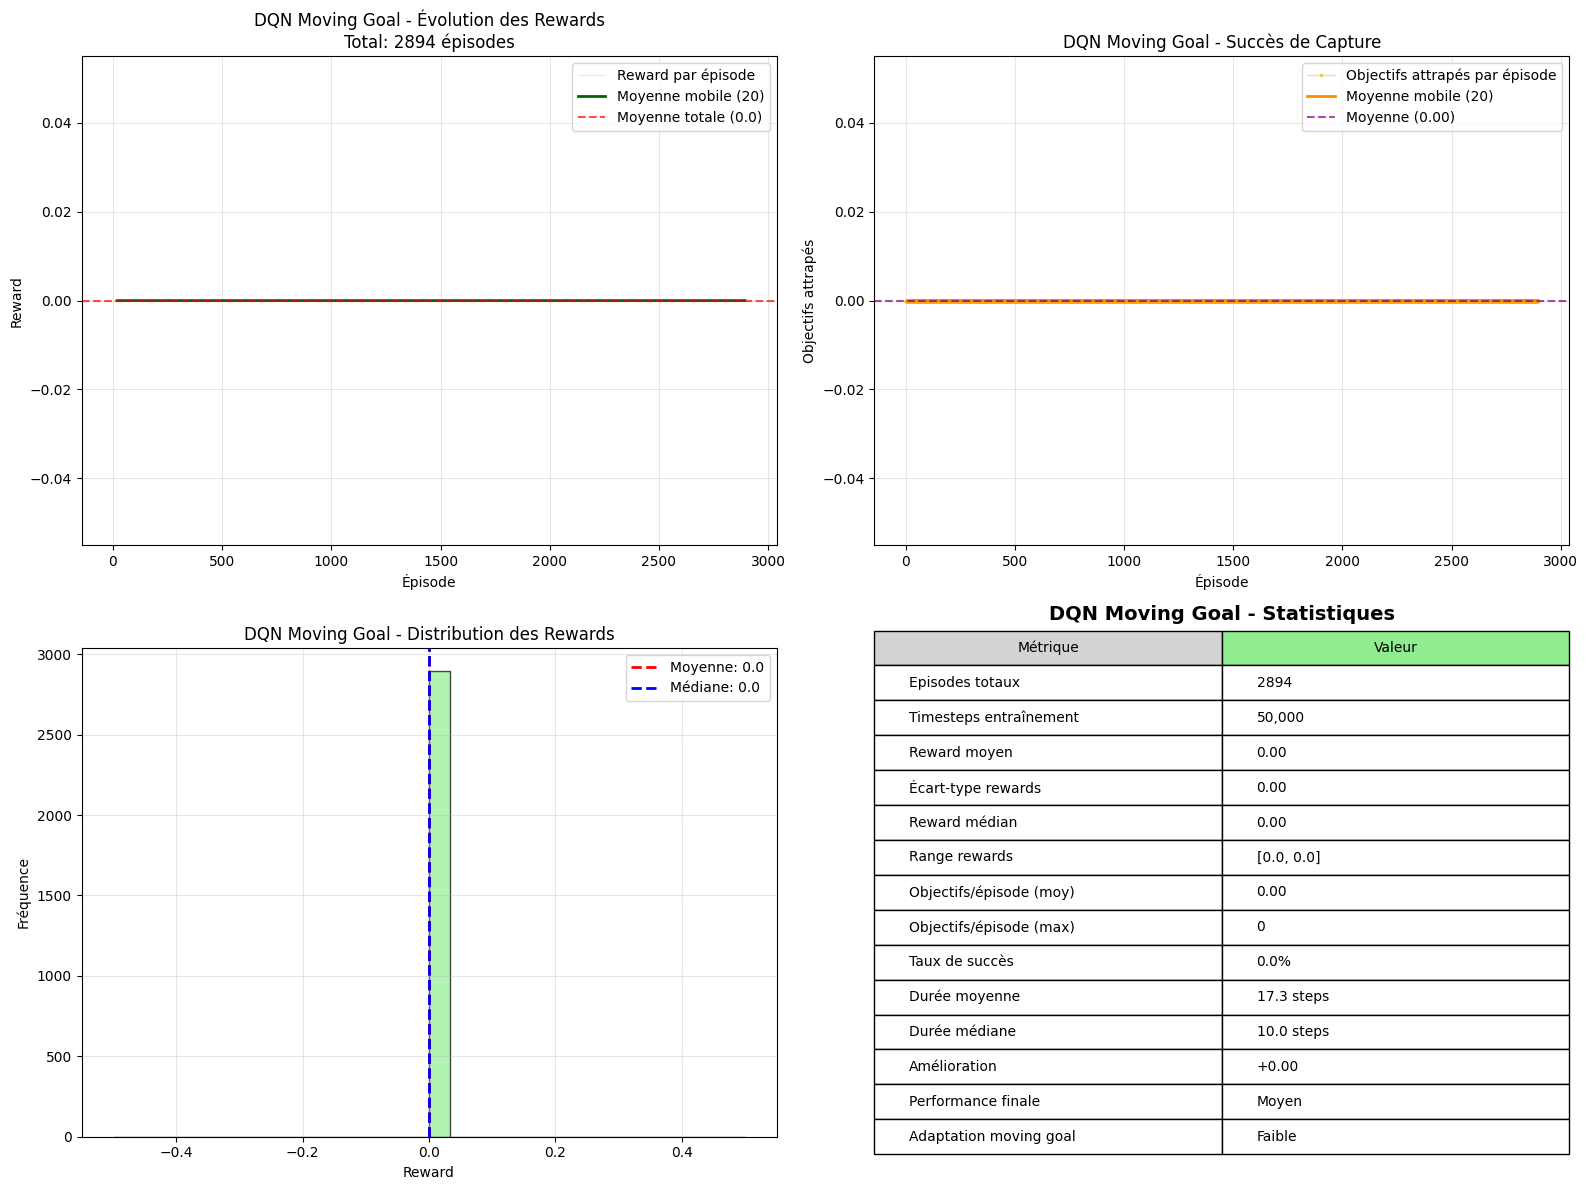


Résumé DQN Moving Goal:
Episodes: 2894 | Timesteps: 50,000 | Durée: 95.1s
Reward moyen: 0.00 ± 0.00
Objectifs attrapés/épisode: 0.00 (max: 0)
Taux de succès: 0.0% des épisodes
Adaptation: Faible
Amélioration: +0.00 | Performance: Moyen


In [83]:
# Visualisation de convergence DQN Moving Goal
def plot_moving_goal_dqn_convergence(recorder, save_path="dqn_moving_goal_convergence.png"):
    """Visualise la convergence de l'entraînement DQN sur objectif mobile"""
    
    if len(recorder.episode_rewards) == 0:
        print("Pas de données d'épisodes disponibles pour DQN Moving Goal")
        return
    
    episodes = list(range(1, len(recorder.episode_rewards) + 1))
    rewards = np.array(recorder.episode_rewards)
    lengths = np.array(recorder.episode_lengths) if len(recorder.episode_lengths) > 0 else None
    catches = np.array(recorder.goal_catches) if len(recorder.goal_catches) > 0 else None
    
    # Moyennes mobiles
    window_size = max(1, min(20, len(rewards) // 5))
    if window_size > 1:
        moving_avg_rewards = np.convolve(rewards, np.ones(window_size), 'valid') / window_size
        moving_avg_episodes = episodes[window_size-1:]
        
        if lengths is not None:
            moving_avg_lengths = np.convolve(lengths, np.ones(window_size), 'valid') / window_size
        if catches is not None:
            moving_avg_catches = np.convolve(catches, np.ones(window_size), 'valid') / window_size
    else:
        moving_avg_rewards = rewards
        moving_avg_episodes = episodes
        moving_avg_lengths = lengths
        moving_avg_catches = catches
    
    # Création du graphique avec 4 sous-graphiques
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Graphique 1: Evolution des rewards
    ax1.plot(episodes, rewards, alpha=0.3, color='lightgreen', linewidth=1, label='Reward par épisode')
    if window_size > 1:
        ax1.plot(moving_avg_episodes, moving_avg_rewards, color='darkgreen', linewidth=2, 
                label=f'Moyenne mobile ({window_size})')
    
    ax1.axhline(y=np.mean(rewards), color='red', linestyle='--', alpha=0.7, 
               label=f'Moyenne totale ({np.mean(rewards):.1f})')
    
    ax1.set_xlabel('Épisode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'DQN Moving Goal - Évolution des Rewards\nTotal: {len(episodes)} épisodes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Objectifs attrapés par épisode
    if catches is not None:
        ax2.plot(episodes, catches, alpha=0.4, color='orange', linewidth=1, 
                label='Objectifs attrapés par épisode', marker='o', markersize=2)
        if window_size > 1:
            ax2.plot(moving_avg_episodes, moving_avg_catches, color='darkorange', linewidth=2,
                    label=f'Moyenne mobile ({window_size})')
        
        ax2.axhline(y=np.mean(catches), color='purple', linestyle='--', alpha=0.7,
                   label=f'Moyenne ({np.mean(catches):.2f})')
        
        ax2.set_xlabel('Épisode')
        ax2.set_ylabel('Objectifs attrapés')
        ax2.set_title('DQN Moving Goal - Succès de Capture')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Données de capture\nnon disponibles', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=14)
    
    # Graphique 3: Distribution des rewards
    ax3.hist(rewards, bins=min(30, len(rewards)//3), alpha=0.7, color='lightgreen', edgecolor='black')
    ax3.axvline(x=np.mean(rewards), color='red', linestyle='--', linewidth=2,
               label=f'Moyenne: {np.mean(rewards):.1f}')
    ax3.axvline(x=np.median(rewards), color='blue', linestyle='--', linewidth=2,
               label=f'Médiane: {np.median(rewards):.1f}')
    
    ax3.set_xlabel('Reward')
    ax3.set_ylabel('Fréquence')
    ax3.set_title('DQN Moving Goal - Distribution des Rewards')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Graphique 4: Statistiques et efficacité
    ax4.axis('off')
    
    # Calcul des statistiques spéciales pour Moving Goal
    stats_data = [
        ['Episodes totaux', f'{len(episodes)}'],
        ['Timesteps entraînement', '50,000'],
        ['Reward moyen', f'{np.mean(rewards):.2f}'],
        ['Écart-type rewards', f'{np.std(rewards):.2f}'],
        ['Reward médian', f'{np.median(rewards):.2f}'],
        ['Range rewards', f'[{np.min(rewards):.1f}, {np.max(rewards):.1f}]'],
    ]
    
    if catches is not None and len(catches) > 0:
        success_rate = (catches > 0).sum() / len(catches) * 100
        stats_data.extend([
            ['Objectifs/épisode (moy)', f'{np.mean(catches):.2f}'],
            ['Objectifs/épisode (max)', f'{np.max(catches):.0f}'],
            ['Taux de succès', f'{success_rate:.1f}%'],
        ])
    
    if lengths is not None and len(lengths) > 0:
        stats_data.extend([
            ['Durée moyenne', f'{np.mean(lengths):.1f} steps'],
            ['Durée médiane', f'{np.median(lengths):.1f} steps'],
        ])
    
    # Efficacité d'apprentissage
    if len(rewards) >= 20:
        first_quarter = rewards[:len(rewards)//4]
        last_quarter = rewards[-len(rewards)//4:]
        improvement = np.mean(last_quarter) - np.mean(first_quarter)
        stats_data.append(['Amélioration', f'{improvement:+.2f}'])
        
        final_performance = np.mean(rewards[-10:])
        if final_performance > 50:
            efficiency = "Excellent"
        elif final_performance > 0:
            efficiency = "Bon"
        elif final_performance > -50:
            efficiency = "Moyen"
        else:
            efficiency = "Faible"
        stats_data.append(['Performance finale', efficiency])
    
    # Adaptation spécifique au Moving Goal
    if catches is not None and len(catches) >= 10:
        recent_catches = np.mean(catches[-10:])
        if recent_catches >= 1.5:
            adaptation = "Excellente"
        elif recent_catches >= 1.0:
            adaptation = "Bonne"
        elif recent_catches >= 0.5:
            adaptation = "Moyenne"
        else:
            adaptation = "Faible"
        stats_data.append(['Adaptation moving goal', adaptation])
    
    table = ax4.table(cellText=stats_data,
                     colLabels=['Métrique', 'Valeur'],
                     cellLoc='left',
                     loc='center',
                     colColours=['lightgray', 'lightgreen'])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8)
    
    ax4.set_title('DQN Moving Goal - Statistiques', pad=20, weight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Résumé textuel
    print(f"\nRésumé DQN Moving Goal:")
    print(f"{'='*60}")
    print(f"Episodes: {len(episodes)} | Timesteps: 50,000 | Durée: {mg_training_time:.1f}s")
    print(f"Reward moyen: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    
    if catches is not None and len(catches) > 0:
        success_rate = (catches > 0).sum() / len(catches) * 100
        print(f"Objectifs attrapés/épisode: {np.mean(catches):.2f} (max: {np.max(catches):.0f})")
        print(f"Taux de succès: {success_rate:.1f}% des épisodes")
        print(f"Adaptation: {adaptation}")
    
    if len(rewards) >= 20:
        print(f"Amélioration: {improvement:+.2f} | Performance: {efficiency}")
    
    return {
        'episodes': len(episodes),
        'mean_reward': np.mean(rewards),
        'mean_catches': np.mean(catches) if catches is not None else 0,
        'success_rate': success_rate if catches is not None else 0,
        'adaptation': adaptation if catches is not None and len(catches) >= 10 else 'N/A'
    }

# Générer la visualisation DQN Moving Goal
print("Génération du graphique de convergence DQN Moving Goal...")
mg_dqn_stats = plot_moving_goal_dqn_convergence(mg_recorder)

In [84]:
# Entraînement PPO sur environnement Moving Goal
class MovingGoalPPORecorder(BaseCallback):
    """Callback spécialisé pour PPO sur objectif mobile"""
    
    def __init__(self, env, record_freq=5000, test_freq=3000, verbose=1):
        super(MovingGoalPPORecorder, self).__init__(verbose)
        self.env = env
        self.record_freq = record_freq
        self.test_freq = test_freq
        self.frames = []
        self.episode_rewards = []
        self.episode_lengths = []
        self.goal_catches = []
        self.current_episode_reward = 0
        self.current_episode_length = 0
        self.current_goal_catches = 0
        self.episode_count = 0
        
    def _on_step(self) -> bool:
        self.current_episode_length += 1
        
        # Enregistrer les récompenses (PPO peut avoir des rewards vectorisés)
        reward = self.locals.get('rewards', [0])[0] if 'rewards' in self.locals else 0
        self.current_episode_reward += reward
        
        # Compter les captures d'objectif
        if reward > 90:
            self.current_goal_catches += 1
        
        # Détecter fin d'épisode
        done = self.locals.get('dones', [False])[0] if 'dones' in self.locals else False
        if done:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_lengths.append(self.current_episode_length)
            self.goal_catches.append(self.current_goal_catches)
            self.episode_count += 1
            
            if self.verbose > 0 and self.episode_count % 20 == 0:
                avg_reward = np.mean(self.episode_rewards[-10:])
                avg_catches = np.mean(self.goal_catches[-10:])
                print(f"PPO Episode {self.episode_count}: Avg Reward={avg_reward:.1f}, Avg Catches={avg_catches:.1f}")
            
            # Reset
            self.current_episode_reward = 0
            self.current_episode_length = 0
            self.current_goal_catches = 0
        
        # Test périodique avec enregistrement
        if self.n_calls % self.test_freq == 0:
            frame = self._test_and_record()
            if frame is not None:
                self.frames.append(frame)
                
        return True
    
    def _test_and_record(self):
        """Teste l'agent PPO actuel sur l'objectif mobile"""
        try:
            # Reset pour test
            obs, _ = self.env.reset()
            
            positions = [self.env.env.agent_pos.copy()]
            goal_positions = [self.env.env.goal_pos.copy()]
            episode_reward = 0
            catches = 0
            
            for step in range(25):
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                episode_reward += reward
                positions.append(self.env.env.agent_pos.copy())
                goal_positions.append(self.env.env.goal_pos.copy())
                
                if reward > 90:
                    catches += 1
                
                if terminated or truncated:
                    break
            
            # Créer la frame PPO
            frame = self._create_ppo_moving_goal_frame(positions, goal_positions, 
                                                     episode_reward, catches, self.n_calls)
            return frame
            
        except Exception as e:
            print(f"Erreur lors de l'enregistrement PPO Moving Goal: {e}")
            return None
    
    def _create_ppo_moving_goal_frame(self, positions, goal_positions, reward, catches, step):
        """Crée une frame de visualisation PPO pour l'objectif mobile"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax.set_facecolor('#fff8f0')  # Fond légèrement orangé pour PPO
        
        grid_size = self.env.env.grid_size
        
        # Grille
        for i in range(grid_size):
            for j in range(grid_size):
                color = '#ffffff' if (i + j) % 2 == 0 else '#fef5f0'
                rect = patches.Rectangle(
                    (j, grid_size - i - 1), 1, 1,
                    linewidth=1, edgecolor='#d0a080', facecolor=color, alpha=0.8
                )
                ax.add_patch(rect)
        
        # Dessiner le chemin de l'agent PPO
        if len(positions) > 1:
            path_x = [pos[1] + 0.5 for pos in positions]
            path_y = [grid_size - pos[0] - 0.5 for pos in positions]
            ax.plot(path_x, path_y, color='#ff6600', linewidth=3, alpha=0.8,
                   linestyle='-', label='Chemin agent PPO')
        
        # Dessiner le chemin de l'objectif mobile
        if len(goal_positions) > 1:
            goal_x = [pos[1] + 0.5 for pos in goal_positions]
            goal_y = [grid_size - pos[0] - 0.5 for pos in goal_positions]
            ax.plot(goal_x, goal_y, color='#9932cc', linewidth=3, alpha=0.7,
                   linestyle=':', label='Chemin objectif mobile', marker='s', markersize=5)
        
        # Dessiner les obstacles
        for obs in self.env.env.obstacles:
            x, y = obs[1], grid_size - obs[0] - 1
            rect = patches.Rectangle(
                (x, y), 1, 1, linewidth=2, edgecolor='#8b4513', facecolor='#a0522d'
            )
            ax.add_patch(rect)
        
        # Dessiner l'objectif actuel
        final_goal = goal_positions[-1]
        goal_x = final_goal[1] + 0.5
        goal_y = grid_size - final_goal[0] - 0.5
        
        # Aura mobile plus voyante pour PPO
        goal_aura = patches.Circle(
            (goal_x, goal_y), 0.65, linewidth=0, facecolor='magenta', alpha=0.3
        )
        ax.add_patch(goal_aura)
        
        goal_rect = patches.Rectangle(
            (final_goal[1], grid_size - final_goal[0] - 1), 1, 1,
            linewidth=3, edgecolor='purple', facecolor='magenta'
        )
        ax.add_patch(goal_rect)
        
        # Dessiner l'agent PPO
        final_pos = positions[-1]
        agent_x = final_pos[1] + 0.5
        agent_y = grid_size - final_pos[0] - 0.5
        
        agent_circle = patches.Circle(
            (agent_x, agent_y), 0.35,
            linewidth=2, edgecolor='darkorange', facecolor='moccasin'
        )
        ax.add_patch(agent_circle)
        
        # Grille
        for i in range(grid_size + 1):
            ax.axhline(i, color='#c0a080', linewidth=1, alpha=0.7)
            ax.axvline(i, color='#c0a080', linewidth=1, alpha=0.7)
        
        ax.set_xlim(-0.1, grid_size + 0.1)
        ax.set_ylim(-0.1, grid_size + 0.1)
        ax.set_aspect('equal')
        
        # Titre avec informations PPO
        avg_reward = np.mean(self.episode_rewards[-10:]) if len(self.episode_rewards) >= 10 else 0
        avg_catches = np.mean(self.goal_catches[-10:]) if len(self.goal_catches) >= 10 else 0
        
        ax.set_title(f'PPO Moving Goal Training\\nStep: {step:,} | Test Reward: {reward:.1f} | Catches: {catches}\\n'
                    f'Avg Reward: {avg_reward:.1f} | Avg Catches: {avg_catches:.1f} | Episode: {self.episode_count}', 
                    fontsize=12, weight='bold')
        
        ax.legend(loc='upper right')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Convertir en array
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, facecolor='white', edgecolor='none')
        buf.seek(0)
        plt.close()
        
        import PIL.Image
        img = PIL.Image.open(buf)
        img = img.resize((800, 800), PIL.Image.Resampling.LANCZOS)
        frame = np.array(img)
        buf.close()
        
        return frame

# Configuration et entraînement PPO pour Moving Goal
print("Configuration PPO pour environnement Moving Goal...")

# Hyperparamètres PPO adaptés pour l'objectif mobile
mg_ppo_hyperparams = {
    "learning_rate": 0.0003,
    "n_steps": 2048,
    "batch_size": 64,
    "n_epochs": 10,
    "gamma": 0.95,                # Discount légèrement réduit comme pour DQN
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "ent_coef": 0.02,            # Entropie plus élevée pour plus d'exploration
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "policy": "MlpPolicy",
    "net_arch": "[512, 512, 256]" # Même architecture que DQN
}

print("Hyperparamètres PPO Moving Goal:")
for param, value in mg_ppo_hyperparams.items():
    print(f"{param:20}: {value}")

# Créer un nouvel environnement pour PPO
print("\\nCréation de l'environnement PPO Moving Goal...")
mg_ppo_env = MovingGoalGridWorldWrapper(grid_size=6, obstacles_pattern="sparse", goal_move_freq=12)

# Callback d'enregistrement PPO
print("Création du callback d'enregistrement PPO Moving Goal...")
mg_ppo_recorder = MovingGoalPPORecorder(mg_ppo_env, record_freq=6000, test_freq=4000, verbose=1)

# Modèle PPO pour Moving Goal
print("Création du modèle PPO Moving Goal...")
mg_ppo_model = PPO(
    mg_ppo_hyperparams["policy"],
    mg_ppo_env,
    learning_rate=mg_ppo_hyperparams["learning_rate"],
    n_steps=mg_ppo_hyperparams["n_steps"],
    batch_size=mg_ppo_hyperparams["batch_size"],
    n_epochs=mg_ppo_hyperparams["n_epochs"],
    gamma=mg_ppo_hyperparams["gamma"],
    gae_lambda=mg_ppo_hyperparams["gae_lambda"],
    clip_range=mg_ppo_hyperparams["clip_range"],
    ent_coef=mg_ppo_hyperparams["ent_coef"],
    vf_coef=mg_ppo_hyperparams["vf_coef"],
    max_grad_norm=mg_ppo_hyperparams["max_grad_norm"],
    verbose=1
)

# Entraînement PPO Moving Goal
print("\\nDébut de l'entraînement PPO Moving Goal...")
mg_ppo_start_time = time.time()

mg_ppo_model.learn(total_timesteps=50000, callback=mg_ppo_recorder)

mg_ppo_training_time = time.time() - mg_ppo_start_time
print(f"\\nEntraînement PPO Moving Goal terminé en {mg_ppo_training_time:.2f} secondes")
print(f"Épisodes: {mg_ppo_recorder.episode_count}")
print(f"Frames: {len(mg_ppo_recorder.frames)}")

# Statistiques PPO Moving Goal
if len(mg_ppo_recorder.episode_rewards) > 0:
    print(f"Reward moyen: {np.mean(mg_ppo_recorder.episode_rewards):.2f}")
    print(f"Objectifs attrapés par épisode (moy): {np.mean(mg_ppo_recorder.goal_catches):.2f}")

# Sauvegarder le GIF d'entraînement PPO
if len(mg_ppo_recorder.frames) > 0:
    mg_ppo_training_gif = "ppo_moving_goal_training.gif"
    imageio.mimsave(mg_ppo_training_gif, mg_ppo_recorder.frames, duration=1.0)
    print(f"GIF d'entraînement PPO Moving Goal: {mg_ppo_training_gif}")

# Sauvegarder le modèle PPO
mg_ppo_model.save("ppo_moving_goal_model")
print("Modèle PPO Moving Goal sauvegardé")

Configuration PPO pour environnement Moving Goal...
Hyperparamètres PPO Moving Goal:
learning_rate       : 0.0003
n_steps             : 2048
batch_size          : 64
n_epochs            : 10
gamma               : 0.95
gae_lambda          : 0.95
clip_range          : 0.2
ent_coef            : 0.02
vf_coef             : 0.5
max_grad_norm       : 0.5
policy              : MlpPolicy
net_arch            : [512, 512, 256]
\nCréation de l'environnement PPO Moving Goal...
Création du callback d'enregistrement PPO Moving Goal...
Création du modèle PPO Moving Goal...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
\nDébut de l'entraînement PPO Moving Goal...
PPO Episode 20: Avg Reward=-1.5, Avg Catches=0.7
PPO Episode 20: Avg Reward=-1.5, Avg Catches=0.7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 62       |
|    ep_rew_mean     | -21.4    |
| time/              |          |
|    fps             | 3027  

Évaluation comparative DQN vs PPO sur Moving Goal...


C:\Users\Rog strix Scar\AppData\Local\Temp\ipykernel_24384\1066538482.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True)


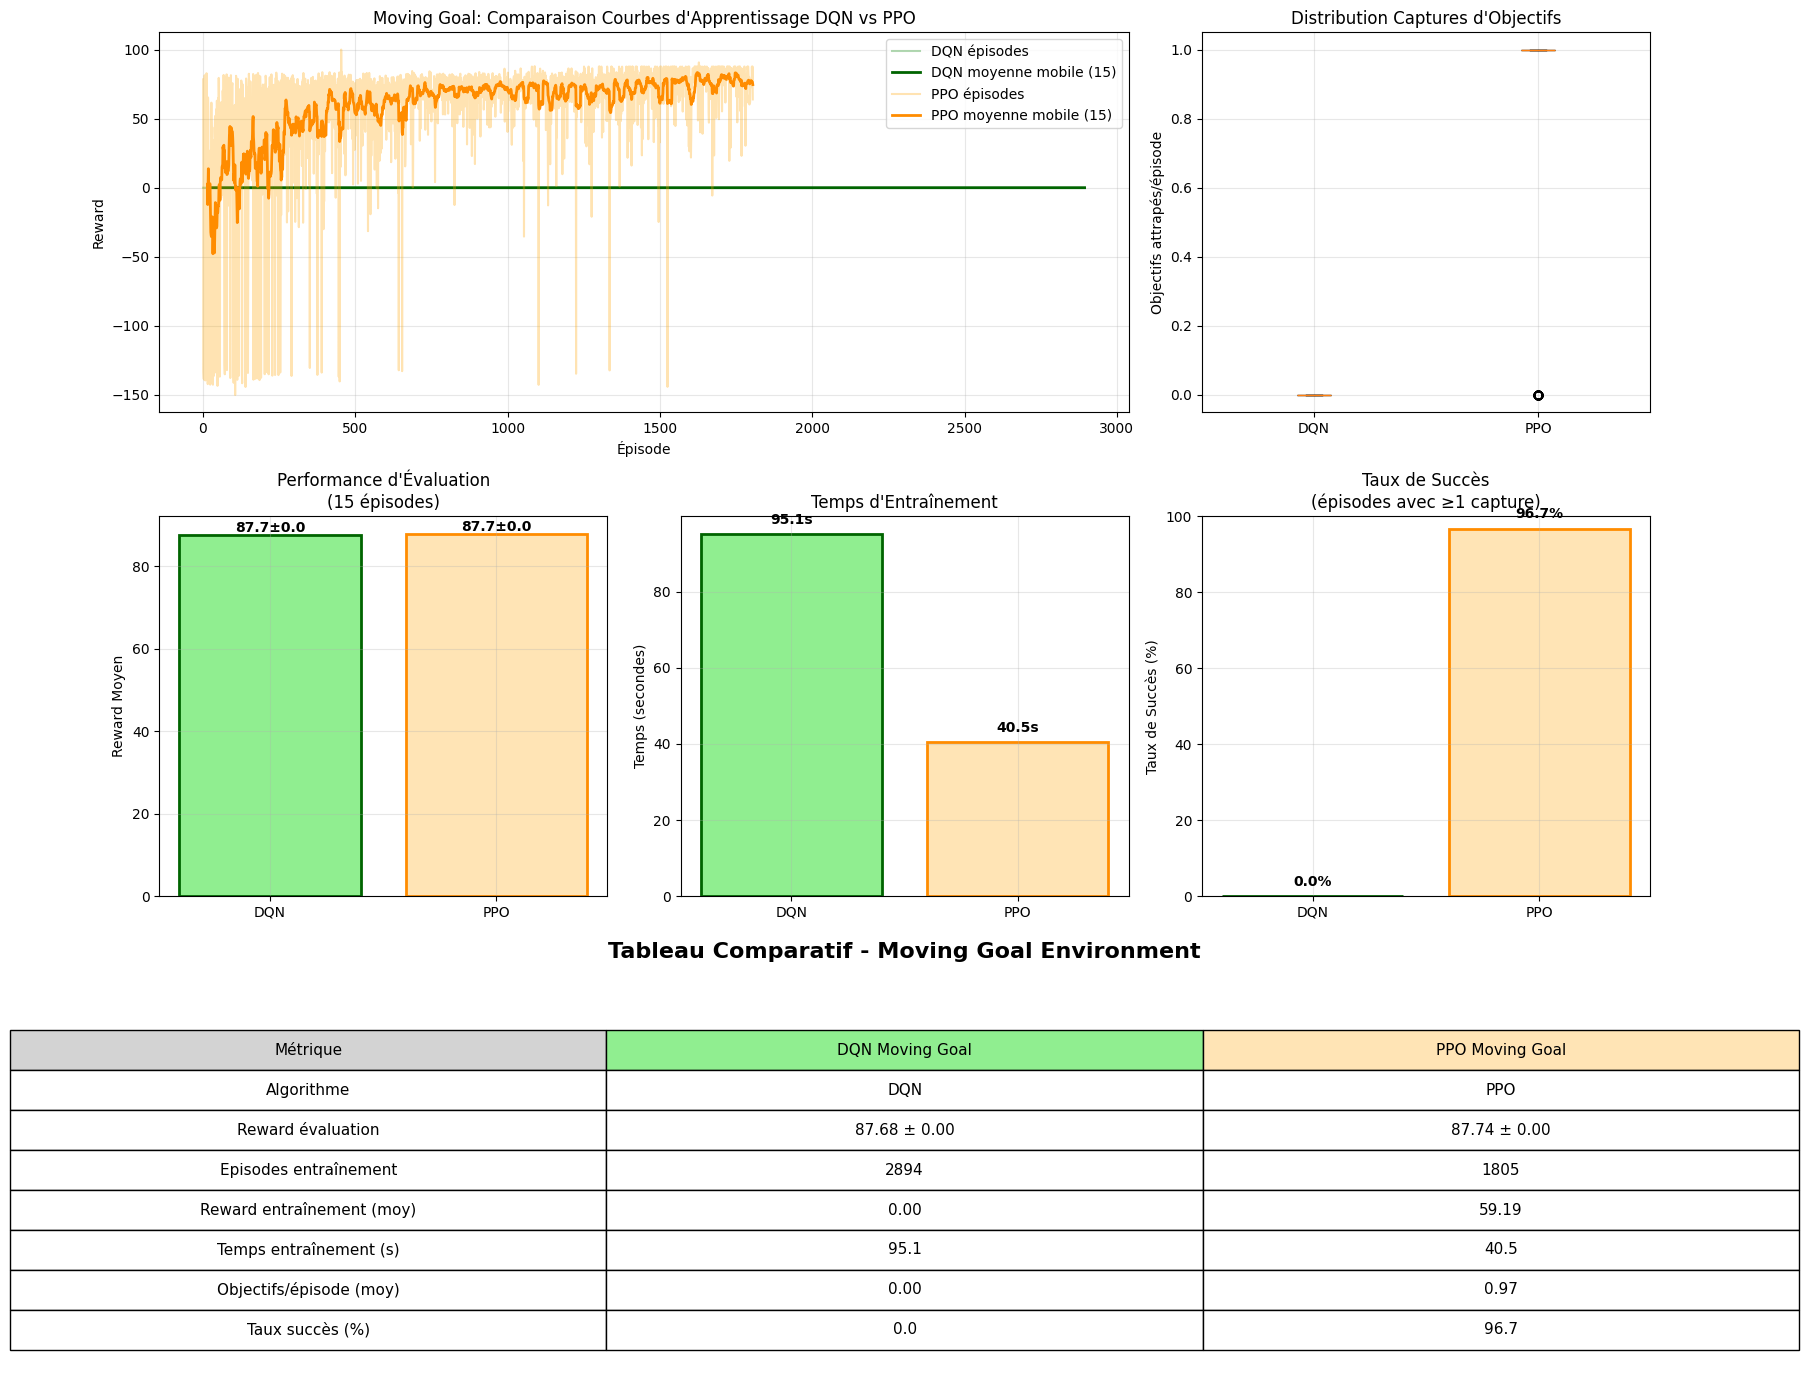


Analyse Comparative Moving Goal - DQN vs PPO:

PERFORMANCES D'ÉVALUATION:
  DQN: 87.68 ± 0.00
  PPO: 87.74 ± 0.00
  Meilleur: PPO (+0.06)

ADAPTATION OBJECTIF MOBILE:
  DQN captures/épisode: 0.00
  PPO captures/épisode: 0.97
  DQN taux succès: 0.0%
  PPO taux succès: 96.7%
  Meilleure adaptation: PPO

EFFICACITÉ TEMPORELLE:
  DQN: 95.1s
  PPO: 40.5s
  Plus rapide: PPO (-54.6s)

RECOMMANDATIONS MOVING GOAL:
  PPO recommandé pour objectifs mobiles
    - Meilleure performance globale
    - Meilleure adaptation aux changements

OPTIMISATIONS POSSIBLES:
  - Ajuster fréquence mouvement objectif
  - Modifier récompenses pour adaptation
  - Tester architectures de réseau plus profondes
  - Augmenter exploration pour environnements dynamiques


In [85]:
# Comparaison DQN vs PPO sur environnement Moving Goal
def compare_moving_goal_algorithms(dqn_model, ppo_model, dqn_recorder, ppo_recorder, env):
    """Compare les performances DQN vs PPO sur objectif mobile"""
    
    print("Évaluation comparative DQN vs PPO sur Moving Goal...")
    
    # Évaluation des modèles
    dqn_mean, dqn_std = evaluate_policy(dqn_model, env, n_eval_episodes=15)
    ppo_mean, ppo_std = evaluate_policy(ppo_model, env, n_eval_episodes=15)
    
    # Données pour comparaison
    dqn_rewards = np.array(dqn_recorder.episode_rewards)
    ppo_rewards = np.array(ppo_recorder.episode_rewards)
    dqn_catches = np.array(dqn_recorder.goal_catches) if hasattr(dqn_recorder, 'goal_catches') else np.array([])
    ppo_catches = np.array(ppo_recorder.goal_catches) if hasattr(ppo_recorder, 'goal_catches') else np.array([])
    
    # Création du graphique de comparaison
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])
    
    # Graphique 1: Courbes d'apprentissage superposées
    ax1 = fig.add_subplot(gs[0, :2])
    
    if len(dqn_rewards) > 0:
        dqn_episodes = range(1, len(dqn_rewards) + 1)
        ax1.plot(dqn_episodes, dqn_rewards, alpha=0.3, color='green', label='DQN épisodes')
        
        window_size = min(15, len(dqn_rewards) // 4)
        if window_size > 1:
            dqn_moving_avg = np.convolve(dqn_rewards, np.ones(window_size), 'valid') / window_size
            ax1.plot(dqn_episodes[window_size-1:], dqn_moving_avg, color='darkgreen', 
                    linewidth=2, label=f'DQN moyenne mobile ({window_size})')
    
    if len(ppo_rewards) > 0:
        ppo_episodes = range(1, len(ppo_rewards) + 1)
        ax1.plot(ppo_episodes, ppo_rewards, alpha=0.3, color='orange', label='PPO épisodes')
        
        window_size = min(15, len(ppo_rewards) // 4)
        if window_size > 1:
            ppo_moving_avg = np.convolve(ppo_rewards, np.ones(window_size), 'valid') / window_size
            ax1.plot(ppo_episodes[window_size-1:], ppo_moving_avg, color='darkorange', 
                    linewidth=2, label=f'PPO moyenne mobile ({window_size})')
    
    ax1.set_xlabel('Épisode')
    ax1.set_ylabel('Reward')
    ax1.set_title('Moving Goal: Comparaison Courbes d\'Apprentissage DQN vs PPO')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Comparaison objectifs attrapés
    ax2 = fig.add_subplot(gs[0, 2])
    
    if len(dqn_catches) > 0 and len(ppo_catches) > 0:
        data_to_plot = [dqn_catches, ppo_catches]
        labels = ['DQN', 'PPO']
        colors = ['lightgreen', 'moccasin']
        
        bp = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        ax2.set_ylabel('Objectifs attrapés/épisode')
        ax2.set_title('Distribution Captures d\'Objectifs')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Données captures\nincomplètes', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Captures d\'Objectifs')
    
    # Graphique 3: Performance d'évaluation
    ax3 = fig.add_subplot(gs[1, 0])
    
    algorithms = ['DQN', 'PPO']
    eval_means = [dqn_mean, ppo_mean]
    eval_stds = [dqn_std, ppo_std]
    
    bars = ax3.bar(algorithms, eval_means, yerr=eval_stds, 
                   color=['lightgreen', 'moccasin'], edgecolor=['darkgreen', 'darkorange'], linewidth=2)
    ax3.set_ylabel('Reward Moyen')
    ax3.set_title('Performance d\'Évaluation\n(15 épisodes)')
    ax3.grid(True, alpha=0.3)
    
    for i, (mean, std) in enumerate(zip(eval_means, eval_stds)):
        ax3.text(i, mean + std/2, f'{mean:.1f}±{std:.1f}', 
                ha='center', va='bottom', weight='bold')
    
    # Graphique 4: Temps d'entraînement
    ax4 = fig.add_subplot(gs[1, 1])
    
    training_times = [mg_training_time, mg_ppo_training_time]
    bars = ax4.bar(algorithms, training_times, 
                   color=['lightgreen', 'moccasin'], edgecolor=['darkgreen', 'darkorange'], linewidth=2)
    ax4.set_ylabel('Temps (secondes)')
    ax4.set_title('Temps d\'Entraînement')
    ax4.grid(True, alpha=0.3)
    
    for i, time_val in enumerate(training_times):
        ax4.text(i, time_val + max(training_times) * 0.02, f'{time_val:.1f}s', 
                ha='center', va='bottom', weight='bold')
    
    # Graphique 5: Taux de succès
    ax5 = fig.add_subplot(gs[1, 2])
    
    if len(dqn_catches) > 0 and len(ppo_catches) > 0:
        dqn_success_rate = (dqn_catches > 0).sum() / len(dqn_catches) * 100
        ppo_success_rate = (ppo_catches > 0).sum() / len(ppo_catches) * 100
        
        success_rates = [dqn_success_rate, ppo_success_rate]
        bars = ax5.bar(algorithms, success_rates, 
                       color=['lightgreen', 'moccasin'], edgecolor=['darkgreen', 'darkorange'], linewidth=2)
        ax5.set_ylabel('Taux de Succès (%)')
        ax5.set_title('Taux de Succès\n(épisodes avec ≥1 capture)')
        ax5.set_ylim(0, 100)
        ax5.grid(True, alpha=0.3)
        
        for i, rate in enumerate(success_rates):
            ax5.text(i, rate + 2, f'{rate:.1f}%', 
                    ha='center', va='bottom', weight='bold')
    else:
        ax5.text(0.5, 0.5, 'Données\nindisponibles', 
                ha='center', va='center', transform=ax5.transAxes, fontsize=12)
        ax5.set_title('Taux de Succès')
    
    # Tableau récapitulatif détaillé
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    # Statistiques détaillées
    dqn_stats_mg = {
        'Algorithme': 'DQN',
        'Reward évaluation': f'{dqn_mean:.2f} ± {dqn_std:.2f}',
        'Episodes entraînement': len(dqn_rewards),
        'Reward entraînement (moy)': f'{np.mean(dqn_rewards):.2f}' if len(dqn_rewards) > 0 else 'N/A',
        'Temps entraînement (s)': f'{mg_training_time:.1f}',
        'Objectifs/épisode (moy)': f'{np.mean(dqn_catches):.2f}' if len(dqn_catches) > 0 else 'N/A',
        'Taux succès (%)': f'{dqn_success_rate:.1f}' if len(dqn_catches) > 0 and len(dqn_catches) > 0 else 'N/A'
    }
    
    ppo_stats_mg = {
        'Algorithme': 'PPO',
        'Reward évaluation': f'{ppo_mean:.2f} ± {ppo_std:.2f}',
        'Episodes entraînement': len(ppo_rewards),
        'Reward entraînement (moy)': f'{np.mean(ppo_rewards):.2f}' if len(ppo_rewards) > 0 else 'N/A',
        'Temps entraînement (s)': f'{mg_ppo_training_time:.1f}',
        'Objectifs/épisode (moy)': f'{np.mean(ppo_catches):.2f}' if len(ppo_catches) > 0 else 'N/A',
        'Taux succès (%)': f'{ppo_success_rate:.1f}' if len(ppo_catches) > 0 and len(ppo_catches) > 0 else 'N/A'
    }
    
    # Créer le tableau
    table_data = []
    metrics = ['Algorithme', 'Reward évaluation', 'Episodes entraînement', 
               'Reward entraînement (moy)', 'Temps entraînement (s)', 
               'Objectifs/épisode (moy)', 'Taux succès (%)']
    
    for metric in metrics:
        table_data.append([metric, dqn_stats_mg.get(metric, 'N/A'), ppo_stats_mg.get(metric, 'N/A')])
    
    table = ax6.table(cellText=table_data, 
                     colLabels=['Métrique', 'DQN Moving Goal', 'PPO Moving Goal'],
                     cellLoc='center',
                     loc='center',
                     colColours=['lightgray', 'lightgreen', 'moccasin'])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)
    
    ax6.set_title('Tableau Comparatif - Moving Goal Environment', pad=30, weight='bold', fontsize=16)
    
    plt.tight_layout()
    plt.savefig('dqn_vs_ppo_moving_goal_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Analyse textuelle détaillée
    print(f"\nAnalyse Comparative Moving Goal - DQN vs PPO:")
    print(f"{'='*70}")
    
    # Performance d'évaluation
    print(f"\nPERFORMANCES D'ÉVALUATION:")
    print(f"  DQN: {dqn_mean:.2f} ± {dqn_std:.2f}")
    print(f"  PPO: {ppo_mean:.2f} ± {ppo_std:.2f}")
    
    if dqn_mean > ppo_mean:
        winner = "DQN"
        diff = dqn_mean - ppo_mean
    else:
        winner = "PPO" 
        diff = ppo_mean - dqn_mean
    print(f"  Meilleur: {winner} (+{diff:.2f})")
    
    # Adaptation à l'objectif mobile
    if len(dqn_catches) > 0 and len(ppo_catches) > 0:
        print(f"\nADAPTATION OBJECTIF MOBILE:")
        print(f"  DQN captures/épisode: {np.mean(dqn_catches):.2f}")
        print(f"  PPO captures/épisode: {np.mean(ppo_catches):.2f}")
        print(f"  DQN taux succès: {dqn_success_rate:.1f}%")
        print(f"  PPO taux succès: {ppo_success_rate:.1f}%")
        
        if np.mean(dqn_catches) > np.mean(ppo_catches):
            print(f"  Meilleure adaptation: DQN")
        else:
            print(f"  Meilleure adaptation: PPO")
    
    # Efficacité temporelle
    print(f"\nEFFICACITÉ TEMPORELLE:")
    print(f"  DQN: {mg_training_time:.1f}s")
    print(f"  PPO: {mg_ppo_training_time:.1f}s")
    
    if mg_training_time < mg_ppo_training_time:
        print(f"  Plus rapide: DQN (-{mg_ppo_training_time - mg_training_time:.1f}s)")
    else:
        print(f"  Plus rapide: PPO (-{mg_training_time - mg_ppo_training_time:.1f}s)")
    
    # Recommandations
    print(f"\nRECOMMANDATIONS MOVING GOAL:")
    
    if dqn_mean > ppo_mean and np.mean(dqn_catches) > np.mean(ppo_catches) if len(dqn_catches) > 0 and len(ppo_catches) > 0 else dqn_mean > ppo_mean:
        print("  DQN recommandé pour objectifs mobiles")
        print("    - Meilleure performance globale")
        if len(dqn_catches) > 0 and len(ppo_catches) > 0 and np.mean(dqn_catches) > np.mean(ppo_catches):
            print("    - Meilleure adaptation aux changements")
    elif ppo_mean > dqn_mean:
        print("  PPO recommandé pour objectifs mobiles")
        print("    - Meilleure performance globale")
        if len(dqn_catches) > 0 and len(ppo_catches) > 0 and np.mean(ppo_catches) > np.mean(dqn_catches):
            print("    - Meilleure adaptation aux changements")
    else:
        print("  Performances similaires")
        print("    - Choisir selon contraintes temporelles")
    
    print(f"\nOPTIMISATIONS POSSIBLES:")
    print("  - Ajuster fréquence mouvement objectif")
    print("  - Modifier récompenses pour adaptation")
    print("  - Tester architectures de réseau plus profondes")
    print("  - Augmenter exploration pour environnements dynamiques")

# Lancer la comparaison Moving Goal
compare_moving_goal_algorithms(mg_dqn_model, mg_ppo_model, mg_recorder, mg_ppo_recorder, mg_env)